In [2]:
import numpy as np
import glob
import sys
import pickle



In [5]:
results = []
counts = {}
total_count = 0
feature_count = 56963

In [3]:
list_of_sample_directories = glob.glob('./'+'TCGA_*/')

In [26]:
list_of_sample_directories

['./TCGA_KIRC/',
 './TCGA_LIHC/',
 './TCGA_LUAD/',
 './TCGA_PRAD/',
 './TCGA_STAD/',
 './TCGA_UCEC/',
 './TCGA_BRCA/',
 './TCGA_COAD/',
 './TCGA_HNSC/',
 './TCGA_KIRP/',
 './TCGA_LUSC/',
 './TCGA_THCA/']

In [6]:
for directory in list_of_sample_directories:
    all_samples = glob.glob(directory+'*TCGA*.csv')
    counts[directory] = len(all_samples)
    total_count += len(all_samples)

In [28]:
counts

{'./TCGA_BRCA/': 1204,
 './TCGA_COAD/': 497,
 './TCGA_HNSC/': 544,
 './TCGA_KIRC/': 602,
 './TCGA_KIRP/': 320,
 './TCGA_LIHC/': 421,
 './TCGA_LUAD/': 572,
 './TCGA_LUSC/': 550,
 './TCGA_PRAD/': 547,
 './TCGA_STAD/': 407,
 './TCGA_THCA/': 560,
 './TCGA_UCEC/': 578}

In [42]:
counter = 0 
sample_mat = np.zeros((total_count,feature_count))
all_names = []
for directory in list_of_sample_directories:
    all_samples = glob.glob(directory+'*TCGA*.csv')
    for sample in all_samples:
        all_names.append(sample)
        with open(sample,'r') as sample_file:
            line_counter = 0
            for line in sample_file:
                sample_mat[counter,line_counter] = line.strip().split('\t')[1]
                line_counter += 1 
        counter += 1

KeyboardInterrupt: 

In [31]:
sample_mat

array([[  1.99100000e+03,   1.00000000e+00,   1.59600000e+03, ...,
          1.00000000e+00,   4.50000000e+01,   2.00000000e+00],
       [  2.92600000e+03,   4.00000000e+00,   1.46300000e+03, ...,
          0.00000000e+00,   1.19000000e+02,   1.00000000e+00],
       [  2.15000000e+03,   4.50000000e+01,   1.17500000e+03, ...,
          0.00000000e+00,   2.87000000e+02,   0.00000000e+00],
       ..., 
       [  4.63100000e+03,   3.00000000e+00,   2.28600000e+03, ...,
          0.00000000e+00,   2.13000000e+02,   0.00000000e+00],
       [  4.52100000e+03,   3.00000000e+00,   2.89600000e+03, ...,
          0.00000000e+00,   2.09000000e+02,   4.00000000e+00],
       [  3.67000000e+03,   2.00000000e+00,   1.92000000e+03, ...,
          0.00000000e+00,   1.95000000e+02,   1.00000000e+00]])

In [34]:
np.save('./aggregate.npy',sample_mat)
# pickle.dump(open('stats.pkl','wb'),counts)

In [36]:
pickle.dump(counts,open('stats.pkl','wb'))

In [42]:
min_val = np.min(sample_mat,axis=0)
max_val = np.max(sample_mat,axis=0)


In [44]:
(sample_mat-min_val)/(max_val-min_val)

/usr/local/miniconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[  4.24572284e-02,   1.00200401e-04,   8.97319400e-02, ...,
          2.50000000e-02,   3.42205323e-02,   5.52486188e-03],
       [  6.27317475e-02,   4.00801603e-04,   8.21785552e-02, ...,
          0.00000000e+00,   9.04942966e-02,   2.76243094e-03],
       [  4.59049808e-02,   4.50901804e-03,   6.58223535e-02, ...,
          0.00000000e+00,   2.18250951e-01,   0.00000000e+00],
       ..., 
       [  9.97029295e-02,   3.00601202e-04,   1.28918673e-01, ...,
          0.00000000e+00,   1.61977186e-01,   0.00000000e+00],
       [  9.73176920e-02,   3.00601202e-04,   1.63562017e-01, ...,
          0.00000000e+00,   1.58935361e-01,   1.10497238e-02],
       [  7.88646269e-02,   2.00400802e-04,   1.08132667e-01, ...,
          0.00000000e+00,   1.48288973e-01,   2.76243094e-03]])

In [46]:
np.sum(max_val-min_val == 0)

1281

In [56]:
new_mat = sample_mat[:,~(max_val-min_val == 0)]

In [55]:
np.save('invalids.npy',max_val-min_val == 0)

In [57]:
min_val = np.min(new_mat,axis=0)
max_val = np.max(new_mat,axis=0)

In [59]:
normalized_mat = (new_mat-min_val)/(max_val-min_val)

In [60]:
np.save('normalized_agg.npy',normalized_mat)

In [1]:
import pandas as pd
import tensorflow as tf

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc

In [3]:
normalized_mat = np.load('normalized_agg.npy')

In [42]:
from vae_regression import VariantionalAutoencoder

In [11]:
class BatchMaker(object):
    def __init__(self):
        self.batch_number = -1
    def load_data(self,data):
        self.data = data
        self.shuffle()
    
    def shuffle(self):
        self.current_q = np.random.permutation(self.data.shape[0])
        self.head = 0
        self.batch_number += 1
    def get_batch(self,batch_size):
        if self.current_q.shape[0]-self.head >= batch_size:
            result = self.data[self.current_q[self.head:self.head+batch_size],:]
            self.head += batch_size
            return result
        else:
            if self.head == self.current_q.shape[0]:
                self.shuffle()
                self.head = batch_size
                return self.data[self.current_q[:batch_size],:]
            else:
                result = self.data[self.current_q[self.head:],:]
                self.shuffle()
                return result
        return None

In [45]:
tf.reset_default_graph()
vindim = 55682#normalized_mat.shape[1]
model = VariantionalAutoencoder2(learning_rate=1e-4, batch_size=100, n_z=500,vindim=vindim)

In [43]:
class VariantionalAutoencoder2(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10,vindim=100):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z
        self.vindim = vindim
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, self.vindim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f0 = fc(self.x, 30000, scope='enc_fc0', activation_fn=tf.nn.relu)
        f1 = fc(f0, 15000, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 10000, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 2000, scope='enc_fc3', activation_fn=tf.nn.relu)
        #f3 = fc(f3, 500, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        #zzz = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps
        #self.zzz = tf.Print(zzz,[zzz], message="my Z-values:")
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps
        
        # Decode
        # z -> x_hat
        g1 = fc(self.z, 2000, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 10000, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 15000, scope='dec_fc3', activation_fn=tf.nn.relu)
        g4 = fc(g3, 30000, scope='dec_fc4', activation_fn=tf.nn.relu)
        self.x_hat = fc(g4, self.vindim, scope='dec_fc5', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-9
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+ (1-self.x_hat)), 
            axis=1
        )
        #recon_loss = tf.reduce_sum((self.x_hat-self.x)**2,axis=1)

        #recon_loss = tf.nn.l2_loss(self.x_hat-self.x)
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(latent_loss + recon_loss)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.total_loss)
        #self.train_op = tf.train.AdamOptimizer(
        #    learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )

        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [16]:
dataset = BatchMaker()

In [17]:
dataset.load_data(normalized_mat)

In [20]:
loss = model.run_single_step(dataset.get_batch(20))

In [23]:
counter = 0
loss_list = []

In [ ]:
while dataset.batch_number < 2:
    loss = model.run_single_step(dataset.get_batch(20))
    counter += 1 
    if counter % 5 == 0 :
        print(loss) 
    loss_list.append(loss)

(35195.207, 35193.617, 1.5906706)
(10402.766, 10390.831, 11.935358)
(7179.2554, 7176.1353, 3.1202052)
(7249.2002, 7248.147, 1.0526345)
(6833.1694, 6832.8921, 0.27773151)
(8823.7773, 8823.3516, 0.42567492)
(7024.6436, 7024.4829, 0.16086145)
(7069.2529, 7069.1626, 0.090181746)
(8624.2676, 8623.8213, 0.44605798)
(7555.4648, 7555.1157, 0.3484495)
(7852.0156, 7851.8057, 0.21010928)
(6210.2173, 6210.1553, 0.062078722)
(7129.1938, 7128.9922, 0.2020804)
(6856.022, 6855.7173, 0.3050766)
(7253.6157, 7234.2646, 19.350285)
(6391.8779, 6391.2803, 0.59764552)
(7201.4248, 7200.7109, 0.71457922)
(6388.665, 6388.3311, 0.33371228)
(8745.4453, 8742.207, 3.2388482)


In [46]:
saver = tf.train.Saver()

In [28]:
saver.save(model.sess,'vae_all_rms.ckpt')

'vae_all_rms.ckpt'

In [47]:
temp_mod = saver.restore(model.sess,'vae_all_rms.ckpt')

INFO:tensorflow:Restoring parameters from vae_all_rms.ckpt


In [29]:
transformed = model.transformer(normalized_mat)

In [30]:
import matplotlib.pyplot as plt 
%matplotlib inline

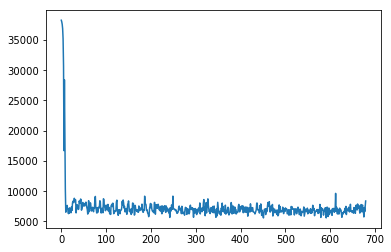

In [33]:
plt.plot([item[1] for item in loss_list])

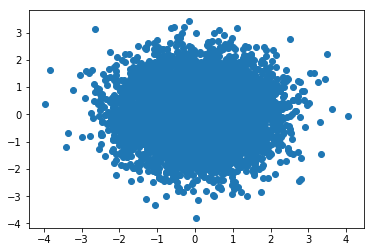

In [35]:
plt.scatter(transformed[:,498],transformed[:,499])

In [43]:
diags = np.zeros((transformed.shape[0],1))
counter = 0 
for directory in list_of_sample_directories:
    all_samples = glob.glob(directory+'*TCGA*.csv')
    for sample in all_samples:
        if 'cancer' in sample:
            diags[counter] = 1
        elif 'normal' in sample:
            diags[counter] = 0
        else:
            print("ERRROOORRR")
        counter += 1
            

In [44]:
np.save('diags.npy',diags)
np.save('transformed.npy',transformed)

In [8]:
diags = np.load('diags.npy')
transformed = np.load('transformed.npy')

In [12]:
list_of_sample_directories
    

['./TCGA_KIRC/',
 './TCGA_LIHC/',
 './TCGA_LUAD/',
 './TCGA_PRAD/',
 './TCGA_STAD/',
 './TCGA_UCEC/',
 './TCGA_BRCA/',
 './TCGA_COAD/',
 './TCGA_HNSC/',
 './TCGA_KIRP/',
 './TCGA_LUSC/',
 './TCGA_THCA/']

In [80]:
def do_regression(vat,np_diags,epochs):
    tf.reset_default_graph()
    model = LogisticRegressor(learning_rate=1e-4,input_dim=vat.shape[1])
    print('TRAINIG LATENT REGRESSOR:')
    bm = BatchMaker()
    bm.load_data(np.concatenate([vat,np_diags],axis=1))
    
    while bm.batch_number < epochs:
        
        batch = bm.get_batch(100)
        loss = model.run_single_step(batch[:,:vat.shape[1]],batch[:,-1:])
            
        if bm.batch_number % 5 == 0:
            print('[Epoch {}] Loss: {}'.format(bm.batch_number, loss))
    labels = model.classifier(vat)
    latent_reg_acc = np.sum(labels[:] == np_diags[:,0])/np_diags.shape[0]
    print('Latent Regressor Accuracy is :',latent_reg_acc)
    return model

In [34]:
sample_count = counts['./TCGA_KIRC/']
model = do_regression(transformed[:sample_count,:],diags[:sample_count,:],550)

TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931471228599548
[Epoch 0] Loss: 0.6923580169677734
[Epoch 0] Loss: 0.691753625869751
[Epoch 0] Loss: 0.6906952261924744
[Epoch 0] Loss: 0.6907861828804016
[Epoch 0] Loss: 0.6891997456550598
[Epoch 0] Loss: 0.6881237030029297
[Epoch 0] Loss: 0.6885817646980286
[Epoch 0] Loss: 0.6863484978675842
[Epoch 0] Loss: 0.6846405863761902
[Epoch 0] Loss: 0.6842676401138306
[Epoch 0] Loss: 0.6835098266601562
[Epoch 0] Loss: 0.6813885569572449
[Epoch 0] Loss: 0.6803941130638123
[Epoch 0] Loss: 0.6814653873443604
[Epoch 0] Loss: 0.679645299911499
[Epoch 0] Loss: 0.6825259327888489
[Epoch 0] Loss: 0.6866220235824585
[Epoch 0] Loss: 0.6821320652961731
[Epoch 0] Loss: 0.6803461909294128
[Epoch 5] Loss: 0.6590076684951782
[Epoch 5] Loss: 0.6299746632575989
[Epoch 5] Loss: 0.595655083656311
[Epoch 5] Loss: 0.6320047974586487
[Epoch 5] Loss: 0.5977622270584106
[Epoch 5] Loss: 0.5798309445381165
[Epoch 5] Loss: 0.6238127946853638
[Epoch 5] Loss: 0.60097897052764

[Epoch 60] Loss: 0.6340206861495972
[Epoch 60] Loss: 0.31121012568473816
[Epoch 60] Loss: 0.3127385973930359
[Epoch 60] Loss: 0.2587732970714569
[Epoch 60] Loss: 0.3395170569419861
[Epoch 60] Loss: 0.456155002117157
[Epoch 60] Loss: 0.25551116466522217
[Epoch 60] Loss: 0.4412928819656372
[Epoch 60] Loss: 0.32615622878074646
[Epoch 60] Loss: 0.38026511669158936
[Epoch 60] Loss: 0.35557255148887634
[Epoch 60] Loss: 0.29304981231689453
[Epoch 60] Loss: 0.25345489382743835
[Epoch 60] Loss: 0.3480721414089203
[Epoch 60] Loss: 0.4510880708694458
[Epoch 60] Loss: 0.32875949144363403
[Epoch 60] Loss: 0.34725794196128845
[Epoch 60] Loss: 0.37201640009880066
[Epoch 60] Loss: 0.23708046972751617
[Epoch 60] Loss: 0.3604622185230255
[Epoch 60] Loss: 0.3142619729042053
[Epoch 65] Loss: 0.3795841336250305
[Epoch 65] Loss: 0.3390340209007263
[Epoch 65] Loss: 0.31736117601394653
[Epoch 65] Loss: 0.3876200318336487
[Epoch 65] Loss: 0.31741058826446533
[Epoch 65] Loss: 0.28030022978782654
[Epoch 65] Loss

[Epoch 120] Loss: 0.08207404613494873
[Epoch 120] Loss: 0.24215735495090485
[Epoch 120] Loss: 0.3099483847618103
[Epoch 120] Loss: 0.3057965338230133
[Epoch 120] Loss: 0.23926891386508942
[Epoch 120] Loss: 0.2642366290092468
[Epoch 120] Loss: 0.3633497357368469
[Epoch 120] Loss: 0.2095227688550949
[Epoch 120] Loss: 0.2890917658805847
[Epoch 120] Loss: 0.19959500432014465
[Epoch 120] Loss: 0.23380978405475616
[Epoch 120] Loss: 0.3020661473274231
[Epoch 120] Loss: 0.21080613136291504
[Epoch 120] Loss: 0.312436580657959
[Epoch 120] Loss: 0.33562973141670227
[Epoch 120] Loss: 0.24790485203266144
[Epoch 120] Loss: 0.20174047350883484
[Epoch 120] Loss: 0.2587023973464966
[Epoch 120] Loss: 0.24954749643802643
[Epoch 120] Loss: 0.19742950797080994
[Epoch 120] Loss: 0.13767163455486298
[Epoch 125] Loss: 0.058838654309511185
[Epoch 125] Loss: 0.19008798897266388
[Epoch 125] Loss: 0.30760860443115234
[Epoch 125] Loss: 0.2445153146982193
[Epoch 125] Loss: 0.24411948025226593
[Epoch 125] Loss: 0.15

[Epoch 180] Loss: 0.01374436542391777
[Epoch 180] Loss: 0.16179344058036804
[Epoch 180] Loss: 0.20009739696979523
[Epoch 180] Loss: 0.2855767607688904
[Epoch 180] Loss: 0.1387241780757904
[Epoch 180] Loss: 0.18960541486740112
[Epoch 180] Loss: 0.15530556440353394
[Epoch 180] Loss: 0.18883095681667328
[Epoch 180] Loss: 0.2065938115119934
[Epoch 180] Loss: 0.16626374423503876
[Epoch 180] Loss: 0.14533938467502594
[Epoch 180] Loss: 0.17556799948215485
[Epoch 180] Loss: 0.2277948260307312
[Epoch 180] Loss: 0.28542599081993103
[Epoch 180] Loss: 0.13773219287395477
[Epoch 180] Loss: 0.2273256778717041
[Epoch 180] Loss: 0.14889882504940033
[Epoch 180] Loss: 0.32444459199905396
[Epoch 180] Loss: 0.22758910059928894
[Epoch 180] Loss: 0.23326094448566437
[Epoch 180] Loss: 0.22432450950145721
[Epoch 185] Loss: 0.053104255348443985
[Epoch 185] Loss: 0.2106495499610901
[Epoch 185] Loss: 0.19925855100154877
[Epoch 185] Loss: 0.12917567789554596
[Epoch 185] Loss: 0.16112039983272552
[Epoch 185] Loss:

[Epoch 240] Loss: 0.07197573781013489
[Epoch 240] Loss: 0.18776682019233704
[Epoch 240] Loss: 0.13673748075962067
[Epoch 240] Loss: 0.1457955539226532
[Epoch 240] Loss: 0.07878769189119339
[Epoch 240] Loss: 0.1379854530096054
[Epoch 240] Loss: 0.14405162632465363
[Epoch 240] Loss: 0.12037491053342819
[Epoch 240] Loss: 0.15620653331279755
[Epoch 240] Loss: 0.23423291742801666
[Epoch 240] Loss: 0.1961689293384552
[Epoch 240] Loss: 0.20141437649726868
[Epoch 240] Loss: 0.1502770483493805
[Epoch 240] Loss: 0.19536510109901428
[Epoch 240] Loss: 0.14423544704914093
[Epoch 240] Loss: 0.16773121058940887
[Epoch 240] Loss: 0.15531612932682037
[Epoch 240] Loss: 0.10689688473939896
[Epoch 240] Loss: 0.16177916526794434
[Epoch 240] Loss: 0.22910217940807343
[Epoch 240] Loss: 0.21677395701408386
[Epoch 245] Loss: 0.03271079435944557
[Epoch 245] Loss: 0.17348124086856842
[Epoch 245] Loss: 0.10143639892339706
[Epoch 245] Loss: 0.15145769715309143
[Epoch 245] Loss: 0.16890695691108704
[Epoch 245] Loss

[Epoch 300] Loss: 0.19061288237571716
[Epoch 300] Loss: 0.12772448360919952
[Epoch 300] Loss: 0.17421619594097137
[Epoch 300] Loss: 0.11748877912759781
[Epoch 300] Loss: 0.10086346417665482
[Epoch 300] Loss: 0.0998477041721344
[Epoch 300] Loss: 0.09647456556558609
[Epoch 300] Loss: 0.14471489191055298
[Epoch 300] Loss: 0.17054827511310577
[Epoch 300] Loss: 0.135303795337677
[Epoch 300] Loss: 0.13338641822338104
[Epoch 300] Loss: 0.1136428490281105
[Epoch 300] Loss: 0.12656359374523163
[Epoch 300] Loss: 0.1188041940331459
[Epoch 300] Loss: 0.11426208168268204
[Epoch 300] Loss: 0.12868249416351318
[Epoch 300] Loss: 0.1216786578297615
[Epoch 300] Loss: 0.10591898113489151
[Epoch 300] Loss: 0.14283610880374908
[Epoch 300] Loss: 0.2036830633878708
[Epoch 300] Loss: 0.2038988173007965
[Epoch 305] Loss: 0.08059646189212799
[Epoch 305] Loss: 0.20240932703018188
[Epoch 305] Loss: 0.1835349202156067
[Epoch 305] Loss: 0.08214538544416428
[Epoch 305] Loss: 0.10231172293424606
[Epoch 305] Loss: 0.1

[Epoch 360] Loss: 0.0800950676202774
[Epoch 360] Loss: 0.1012548953294754
[Epoch 360] Loss: 0.11880925297737122
[Epoch 360] Loss: 0.10420796275138855
[Epoch 360] Loss: 0.11945953220129013
[Epoch 360] Loss: 0.1356711983680725
[Epoch 360] Loss: 0.09030712395906448
[Epoch 360] Loss: 0.08418294787406921
[Epoch 360] Loss: 0.09912445396184921
[Epoch 360] Loss: 0.08398907631635666
[Epoch 360] Loss: 0.09967357665300369
[Epoch 360] Loss: 0.1557014137506485
[Epoch 360] Loss: 0.09991999715566635
[Epoch 360] Loss: 0.12072208523750305
[Epoch 360] Loss: 0.09490994364023209
[Epoch 360] Loss: 0.1511472761631012
[Epoch 360] Loss: 0.12267910689115524
[Epoch 360] Loss: 0.10957230627536774
[Epoch 360] Loss: 0.12022621184587479
[Epoch 360] Loss: 0.10912223160266876
[Epoch 360] Loss: 0.11769808083772659
[Epoch 365] Loss: 0.2947099506855011
[Epoch 365] Loss: 0.09141294658184052
[Epoch 365] Loss: 0.10242795199155807
[Epoch 365] Loss: 0.12078476697206497
[Epoch 365] Loss: 0.10669770836830139
[Epoch 365] Loss: 

[Epoch 420] Loss: 0.11203241348266602
[Epoch 420] Loss: 0.15641231834888458
[Epoch 420] Loss: 0.09653933346271515
[Epoch 420] Loss: 0.11340191960334778
[Epoch 420] Loss: 0.09668975323438644
[Epoch 420] Loss: 0.09421532601118088
[Epoch 420] Loss: 0.11952092498540878
[Epoch 420] Loss: 0.08221790194511414
[Epoch 420] Loss: 0.0806737095117569
[Epoch 420] Loss: 0.08449306339025497
[Epoch 420] Loss: 0.0891646146774292
[Epoch 420] Loss: 0.09065224975347519
[Epoch 420] Loss: 0.07288854569196701
[Epoch 420] Loss: 0.0627991110086441
[Epoch 420] Loss: 0.09061149507761002
[Epoch 420] Loss: 0.10333389788866043
[Epoch 420] Loss: 0.07207382470369339
[Epoch 420] Loss: 0.08047108352184296
[Epoch 420] Loss: 0.11912187933921814
[Epoch 420] Loss: 0.08108130842447281
[Epoch 420] Loss: 0.08133859187364578
[Epoch 425] Loss: 0.10930158197879791
[Epoch 425] Loss: 0.08259411156177521
[Epoch 425] Loss: 0.13276349008083344
[Epoch 425] Loss: 0.10130324214696884
[Epoch 425] Loss: 0.09235522150993347
[Epoch 425] Los

[Epoch 480] Loss: 0.29195302724838257
[Epoch 480] Loss: 0.0944259837269783
[Epoch 480] Loss: 0.07007665932178497
[Epoch 480] Loss: 0.09095299243927002
[Epoch 480] Loss: 0.08322785794734955
[Epoch 480] Loss: 0.04571712017059326
[Epoch 480] Loss: 0.08813778311014175
[Epoch 480] Loss: 0.05874454975128174
[Epoch 480] Loss: 0.07653132826089859
[Epoch 480] Loss: 0.08121189475059509
[Epoch 480] Loss: 0.09802649915218353
[Epoch 480] Loss: 0.058347299695014954
[Epoch 480] Loss: 0.08854160457849503
[Epoch 480] Loss: 0.08449383825063705
[Epoch 480] Loss: 0.06748328357934952
[Epoch 480] Loss: 0.06936313211917877
[Epoch 480] Loss: 0.11267229914665222
[Epoch 480] Loss: 0.08547281473875046
[Epoch 480] Loss: 0.059670642018318176
[Epoch 480] Loss: 0.04935961961746216
[Epoch 480] Loss: 0.0810064747929573
[Epoch 485] Loss: 0.015583459287881851
[Epoch 485] Loss: 0.05790913105010986
[Epoch 485] Loss: 0.0784992128610611
[Epoch 485] Loss: 0.07513485103845596
[Epoch 485] Loss: 0.058617401868104935
[Epoch 485]

[Epoch 540] Loss: 0.004225470125675201
[Epoch 540] Loss: 0.056945279240608215
[Epoch 540] Loss: 0.10269256681203842
[Epoch 540] Loss: 0.06118518486618996
[Epoch 540] Loss: 0.08884727209806442
[Epoch 540] Loss: 0.06557273119688034
[Epoch 540] Loss: 0.06607215851545334
[Epoch 540] Loss: 0.06365571171045303
[Epoch 540] Loss: 0.037995003163814545
[Epoch 540] Loss: 0.058364324271678925
[Epoch 540] Loss: 0.09729556739330292
[Epoch 540] Loss: 0.05615519732236862
[Epoch 540] Loss: 0.09122154116630554
[Epoch 540] Loss: 0.04170021042227745
[Epoch 540] Loss: 0.05015436187386513
[Epoch 540] Loss: 0.06256932020187378
[Epoch 540] Loss: 0.047010134905576706
[Epoch 540] Loss: 0.07259058207273483
[Epoch 540] Loss: 0.0634433776140213
[Epoch 540] Loss: 0.07026529312133789
[Epoch 540] Loss: 0.055478811264038086
[Epoch 545] Loss: 0.003378881374374032
[Epoch 545] Loss: 0.05796562880277634
[Epoch 545] Loss: 0.05254030600190163
[Epoch 545] Loss: 0.053007032722234726
[Epoch 545] Loss: 0.06761516630649567
[Epoc

In [25]:
from regressor import LogisticRegressor

In [15]:
nene =glob.glob('./TCGA_KIRC/'+'*TCGA*.csv')

In [36]:
head_counter = 0
list_of_models = []
list_of_ex_sample = []
for item in list_of_sample_directories:
    sample_count = counts[item]
    vat = transformed[head_counter:head_counter+sample_count]
    
    model = do_regression(vat,diags[head_counter:head_counter+sample_count,:],550)
    w = model.sess.run(model.W)
    b = model.sess.run(model.b)
    
    dists = vat.dot(w) + b

    max_point = vat[np.argmax(dists),:]
    min_point = vat[np.argmin(dists),:]

    cov = np.eye(500)
    cov = cov*0.2

    max_rand = np.random.multivariate_normal(max_point,cov,200)

    min_rand = np.random.multivariate_normal(min_point,cov,200)
    list_of_models.append((w,b))
    list_of_ex_sample.append((max_rand,min_rand))

TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931471228599548
[Epoch 0] Loss: 0.6918343305587769
[Epoch 0] Loss: 0.690836489200592
[Epoch 0] Loss: 0.6921146512031555
[Epoch 0] Loss: 0.6884121298789978
[Epoch 0] Loss: 0.6875843405723572
[Epoch 0] Loss: 0.6880242824554443
[Epoch 0] Loss: 0.6880733966827393
[Epoch 0] Loss: 0.6868959069252014
[Epoch 0] Loss: 0.6852580308914185
[Epoch 0] Loss: 0.6854156255722046
[Epoch 0] Loss: 0.6874216794967651
[Epoch 0] Loss: 0.6798860430717468
[Epoch 0] Loss: 0.6855607628822327
[Epoch 0] Loss: 0.6831168532371521
[Epoch 0] Loss: 0.6812397837638855
[Epoch 0] Loss: 0.6818181872367859
[Epoch 0] Loss: 0.6790092587471008
[Epoch 0] Loss: 0.6781294941902161
[Epoch 0] Loss: 0.6730973124504089
[Epoch 5] Loss: 0.5940659046173096
[Epoch 5] Loss: 0.6110807061195374
[Epoch 5] Loss: 0.5979868769645691
[Epoch 5] Loss: 0.6162013411521912
[Epoch 5] Loss: 0.6135164499282837
[Epoch 5] Loss: 0.6174523234367371
[Epoch 5] Loss: 0.6300138831138611
[Epoch 5] Loss: 0.601047396659

[Epoch 55] Loss: 0.4721352458000183
[Epoch 55] Loss: 0.33190757036209106
[Epoch 55] Loss: 0.27179965376853943
[Epoch 55] Loss: 0.31838294863700867
[Epoch 55] Loss: 0.282937616109848
[Epoch 55] Loss: 0.33870431780815125
[Epoch 55] Loss: 0.3516778349876404
[Epoch 55] Loss: 0.34779420495033264
[Epoch 55] Loss: 0.34236183762550354
[Epoch 55] Loss: 0.28993862867355347
[Epoch 55] Loss: 0.3955826163291931
[Epoch 55] Loss: 0.28121864795684814
[Epoch 55] Loss: 0.31705233454704285
[Epoch 55] Loss: 0.4382524788379669
[Epoch 55] Loss: 0.46822693943977356
[Epoch 55] Loss: 0.3541320264339447
[Epoch 55] Loss: 0.33159106969833374
[Epoch 55] Loss: 0.27683398127555847
[Epoch 55] Loss: 0.3731435239315033
[Epoch 55] Loss: 0.4214426577091217
[Epoch 55] Loss: 0.44613730907440186
[Epoch 60] Loss: 0.5084288120269775
[Epoch 60] Loss: 0.4541985094547272
[Epoch 60] Loss: 0.40655794739723206
[Epoch 60] Loss: 0.35071322321891785
[Epoch 60] Loss: 0.3203863501548767
[Epoch 60] Loss: 0.26173731684684753
[Epoch 60] Lo

[Epoch 115] Loss: 0.20279249548912048
[Epoch 115] Loss: 0.30923256278038025
[Epoch 115] Loss: 0.1938539296388626
[Epoch 115] Loss: 0.2670367658138275
[Epoch 115] Loss: 0.3992401361465454
[Epoch 115] Loss: 0.39730897545814514
[Epoch 115] Loss: 0.2842198312282562
[Epoch 115] Loss: 0.27245065569877625
[Epoch 115] Loss: 0.19822664558887482
[Epoch 115] Loss: 0.23416873812675476
[Epoch 115] Loss: 0.298134446144104
[Epoch 115] Loss: 0.18035081028938293
[Epoch 115] Loss: 0.2638290822505951
[Epoch 115] Loss: 0.2443615347146988
[Epoch 115] Loss: 0.3093659281730652
[Epoch 115] Loss: 0.2571772634983063
[Epoch 115] Loss: 0.18525047600269318
[Epoch 115] Loss: 0.31411805748939514
[Epoch 115] Loss: 0.17373110353946686
[Epoch 115] Loss: 0.2100072205066681
[Epoch 115] Loss: 0.2236553281545639
[Epoch 120] Loss: 0.13008056581020355
[Epoch 120] Loss: 0.2426091879606247
[Epoch 120] Loss: 0.31754064559936523
[Epoch 120] Loss: 0.289687842130661
[Epoch 120] Loss: 0.2768365740776062
[Epoch 120] Loss: 0.27668735

[Epoch 175] Loss: 0.1026918813586235
[Epoch 175] Loss: 0.266592413187027
[Epoch 175] Loss: 0.220500186085701
[Epoch 175] Loss: 0.13178303837776184
[Epoch 175] Loss: 0.2688387632369995
[Epoch 175] Loss: 0.21042484045028687
[Epoch 175] Loss: 0.1912115514278412
[Epoch 175] Loss: 0.1676216721534729
[Epoch 175] Loss: 0.21348212659358978
[Epoch 175] Loss: 0.22009140253067017
[Epoch 175] Loss: 0.2006884217262268
[Epoch 175] Loss: 0.15612606704235077
[Epoch 175] Loss: 0.2510335147380829
[Epoch 175] Loss: 0.2556937634944916
[Epoch 175] Loss: 0.30413341522216797
[Epoch 175] Loss: 0.2154298722743988
[Epoch 175] Loss: 0.16069412231445312
[Epoch 175] Loss: 0.1861293464899063
[Epoch 175] Loss: 0.1880190372467041
[Epoch 175] Loss: 0.1462092250585556
[Epoch 175] Loss: 0.18737754225730896
[Epoch 180] Loss: 0.013038983568549156
[Epoch 180] Loss: 0.16130416095256805
[Epoch 180] Loss: 0.16208459436893463
[Epoch 180] Loss: 0.27051275968551636
[Epoch 180] Loss: 0.2383144348859787
[Epoch 180] Loss: 0.2594819

[Epoch 235] Loss: 0.33736681938171387
[Epoch 235] Loss: 0.1393463909626007
[Epoch 235] Loss: 0.15742681920528412
[Epoch 235] Loss: 0.0893222987651825
[Epoch 235] Loss: 0.10689432173967361
[Epoch 235] Loss: 0.14425547420978546
[Epoch 235] Loss: 0.21132946014404297
[Epoch 235] Loss: 0.20705120265483856
[Epoch 235] Loss: 0.1663815677165985
[Epoch 235] Loss: 0.14674930274486542
[Epoch 235] Loss: 0.08297815173864365
[Epoch 235] Loss: 0.1524011790752411
[Epoch 235] Loss: 0.19741776585578918
[Epoch 235] Loss: 0.13510803878307343
[Epoch 235] Loss: 0.18204620480537415
[Epoch 235] Loss: 0.20876912772655487
[Epoch 235] Loss: 0.18458017706871033
[Epoch 235] Loss: 0.16669267416000366
[Epoch 235] Loss: 0.17325320839881897
[Epoch 235] Loss: 0.22699497640132904
[Epoch 235] Loss: 0.2655392587184906
[Epoch 240] Loss: 0.2959126830101013
[Epoch 240] Loss: 0.14135220646858215
[Epoch 240] Loss: 0.17753475904464722
[Epoch 240] Loss: 0.2163127362728119
[Epoch 240] Loss: 0.1964123398065567
[Epoch 240] Loss: 0.

[Epoch 295] Loss: 0.2865534722805023
[Epoch 295] Loss: 0.13573651015758514
[Epoch 295] Loss: 0.16050618886947632
[Epoch 295] Loss: 0.1357499063014984
[Epoch 295] Loss: 0.10272451490163803
[Epoch 295] Loss: 0.16283713281154633
[Epoch 295] Loss: 0.20917434990406036
[Epoch 295] Loss: 0.25113850831985474
[Epoch 295] Loss: 0.12814049422740936
[Epoch 295] Loss: 0.14325980842113495
[Epoch 295] Loss: 0.09109310060739517
[Epoch 295] Loss: 0.09546960145235062
[Epoch 295] Loss: 0.11286098510026932
[Epoch 295] Loss: 0.12135066837072372
[Epoch 295] Loss: 0.07292762398719788
[Epoch 295] Loss: 0.1753307729959488
[Epoch 295] Loss: 0.07977188378572464
[Epoch 295] Loss: 0.12268515676259995
[Epoch 295] Loss: 0.14262937009334564
[Epoch 295] Loss: 0.14198963344097137
[Epoch 295] Loss: 0.15960168838500977
[Epoch 300] Loss: 0.573750376701355
[Epoch 300] Loss: 0.16813232004642487
[Epoch 300] Loss: 0.10820164531469345
[Epoch 300] Loss: 0.173747256398201
[Epoch 300] Loss: 0.10298151522874832
[Epoch 300] Loss: 0

[Epoch 355] Loss: 0.15959417819976807
[Epoch 355] Loss: 0.11511971056461334
[Epoch 355] Loss: 0.13480184972286224
[Epoch 355] Loss: 0.13826927542686462
[Epoch 355] Loss: 0.13564753532409668
[Epoch 355] Loss: 0.1215818002820015
[Epoch 355] Loss: 0.09552685171365738
[Epoch 355] Loss: 0.07354673743247986
[Epoch 355] Loss: 0.0781622901558876
[Epoch 355] Loss: 0.12851184606552124
[Epoch 355] Loss: 0.136857271194458
[Epoch 355] Loss: 0.1585128903388977
[Epoch 355] Loss: 0.13274438679218292
[Epoch 355] Loss: 0.10608117282390594
[Epoch 355] Loss: 0.12451891601085663
[Epoch 355] Loss: 0.07420175522565842
[Epoch 355] Loss: 0.10477150231599808
[Epoch 355] Loss: 0.09227930754423141
[Epoch 355] Loss: 0.10555621981620789
[Epoch 355] Loss: 0.10186676681041718
[Epoch 355] Loss: 0.10811455547809601
[Epoch 360] Loss: 0.10484383255243301
[Epoch 360] Loss: 0.12049390375614166
[Epoch 360] Loss: 0.09910184890031815
[Epoch 360] Loss: 0.11287881433963776
[Epoch 360] Loss: 0.0984233096241951
[Epoch 360] Loss: 

[Epoch 415] Loss: 0.07998443394899368
[Epoch 415] Loss: 0.07755081355571747
[Epoch 415] Loss: 0.07059970498085022
[Epoch 415] Loss: 0.07346512377262115
[Epoch 415] Loss: 0.12390583008527756
[Epoch 415] Loss: 0.09747043251991272
[Epoch 415] Loss: 0.08676032721996307
[Epoch 415] Loss: 0.10681085288524628
[Epoch 415] Loss: 0.08000542223453522
[Epoch 415] Loss: 0.0883907824754715
[Epoch 415] Loss: 0.09603667259216309
[Epoch 415] Loss: 0.1150021031498909
[Epoch 415] Loss: 0.09811604022979736
[Epoch 415] Loss: 0.06562468409538269
[Epoch 415] Loss: 0.15205946564674377
[Epoch 415] Loss: 0.06768478453159332
[Epoch 415] Loss: 0.10506635159254074
[Epoch 415] Loss: 0.1326259821653366
[Epoch 415] Loss: 0.08556392788887024
[Epoch 415] Loss: 0.08208504319190979
[Epoch 415] Loss: 0.10614781081676483
[Epoch 420] Loss: 0.009637519717216492
[Epoch 420] Loss: 0.11211276054382324
[Epoch 420] Loss: 0.07784329354763031
[Epoch 420] Loss: 0.12547527253627777
[Epoch 420] Loss: 0.11358696967363358
[Epoch 420] Lo

[Epoch 475] Loss: 0.03257271274924278
[Epoch 475] Loss: 0.06500744074583054
[Epoch 475] Loss: 0.0519542470574379
[Epoch 475] Loss: 0.09532177448272705
[Epoch 475] Loss: 0.0839715525507927
[Epoch 475] Loss: 0.06687906384468079
[Epoch 475] Loss: 0.0692848339676857
[Epoch 475] Loss: 0.09547305107116699
[Epoch 475] Loss: 0.06836550682783127
[Epoch 475] Loss: 0.09724249690771103
[Epoch 475] Loss: 0.10413286834955215
[Epoch 475] Loss: 0.09896251559257507
[Epoch 475] Loss: 0.06374628096818924
[Epoch 475] Loss: 0.09097810089588165
[Epoch 475] Loss: 0.07036081701517105
[Epoch 475] Loss: 0.07748787850141525
[Epoch 475] Loss: 0.10731617361307144
[Epoch 475] Loss: 0.07115940749645233
[Epoch 475] Loss: 0.053726062178611755
[Epoch 475] Loss: 0.07740745693445206
[Epoch 475] Loss: 0.09498640894889832
[Epoch 480] Loss: 0.007905848324298859
[Epoch 480] Loss: 0.12981656193733215
[Epoch 480] Loss: 0.07982726395130157
[Epoch 480] Loss: 0.053733766078948975
[Epoch 480] Loss: 0.09484244883060455
[Epoch 480] 

[Epoch 535] Loss: 0.10521192103624344
[Epoch 535] Loss: 0.055457133799791336
[Epoch 535] Loss: 0.07089359313249588
[Epoch 535] Loss: 0.08039066940546036
[Epoch 535] Loss: 0.0757715180516243
[Epoch 535] Loss: 0.08272180706262589
[Epoch 535] Loss: 0.09610240906476974
[Epoch 535] Loss: 0.06928993761539459
[Epoch 535] Loss: 0.06320874392986298
[Epoch 535] Loss: 0.05773817375302315
[Epoch 535] Loss: 0.060276735574007034
[Epoch 535] Loss: 0.05307218059897423
[Epoch 535] Loss: 0.043519265949726105
[Epoch 535] Loss: 0.045532215386629105
[Epoch 535] Loss: 0.06838547438383102
[Epoch 535] Loss: 0.05028507858514786
[Epoch 535] Loss: 0.07008925080299377
[Epoch 535] Loss: 0.05998943746089935
[Epoch 535] Loss: 0.11155009269714355
[Epoch 535] Loss: 0.0638611763715744
[Epoch 535] Loss: 0.07569566369056702
[Epoch 540] Loss: 0.028202442452311516
[Epoch 540] Loss: 0.07017431408166885
[Epoch 540] Loss: 0.07645589858293533
[Epoch 540] Loss: 0.06354077905416489
[Epoch 540] Loss: 0.06347934901714325
[Epoch 54

[Epoch 65] Loss: 0.3314005434513092
[Epoch 65] Loss: 0.21463726460933685
[Epoch 65] Loss: 0.31521445512771606
[Epoch 65] Loss: 0.2564474642276764
[Epoch 65] Loss: 0.23725594580173492
[Epoch 65] Loss: 0.24025243520736694
[Epoch 65] Loss: 0.26483380794525146
[Epoch 65] Loss: 0.23520344495773315
[Epoch 65] Loss: 0.2608000636100769
[Epoch 65] Loss: 0.2598342001438141
[Epoch 65] Loss: 0.261073499917984
[Epoch 65] Loss: 0.21276530623435974
[Epoch 65] Loss: 0.2838168740272522
[Epoch 65] Loss: 0.2602241635322571
[Epoch 65] Loss: 0.2395949512720108
[Epoch 70] Loss: 0.09653861075639725
[Epoch 70] Loss: 0.23592323064804077
[Epoch 70] Loss: 0.23932123184204102
[Epoch 70] Loss: 0.21457821130752563
[Epoch 70] Loss: 0.25025248527526855
[Epoch 70] Loss: 0.2161215990781784
[Epoch 70] Loss: 0.27935630083084106
[Epoch 70] Loss: 0.24304741621017456
[Epoch 70] Loss: 0.2540607750415802
[Epoch 70] Loss: 0.1959935575723648
[Epoch 70] Loss: 0.2108200490474701
[Epoch 70] Loss: 0.2154577225446701
[Epoch 70] Loss

[Epoch 155] Loss: 0.09951416403055191
[Epoch 155] Loss: 0.08337976038455963
[Epoch 155] Loss: 0.11190559715032578
[Epoch 155] Loss: 0.160042867064476
[Epoch 160] Loss: 0.04879147559404373
[Epoch 160] Loss: 0.09924547374248505
[Epoch 160] Loss: 0.12627728283405304
[Epoch 160] Loss: 0.07808046042919159
[Epoch 160] Loss: 0.12478361278772354
[Epoch 160] Loss: 0.09211523085832596
[Epoch 160] Loss: 0.1336759626865387
[Epoch 160] Loss: 0.11266851425170898
[Epoch 160] Loss: 0.101089246571064
[Epoch 160] Loss: 0.1315433531999588
[Epoch 160] Loss: 0.10834971070289612
[Epoch 160] Loss: 0.1284216344356537
[Epoch 160] Loss: 0.10124555230140686
[Epoch 160] Loss: 0.13771101832389832
[Epoch 160] Loss: 0.11808773875236511
[Epoch 165] Loss: 0.06260976195335388
[Epoch 165] Loss: 0.09754489362239838
[Epoch 165] Loss: 0.12419036030769348
[Epoch 165] Loss: 0.10510364919900894
[Epoch 165] Loss: 0.10492663830518723
[Epoch 165] Loss: 0.12817910313606262
[Epoch 165] Loss: 0.10008073598146439
[Epoch 165] Loss: 0

[Epoch 240] Loss: 0.0756056010723114
[Epoch 240] Loss: 0.07677585631608963
[Epoch 245] Loss: 0.15934358537197113
[Epoch 245] Loss: 0.044611606746912
[Epoch 245] Loss: 0.07401169091463089
[Epoch 245] Loss: 0.04619715362787247
[Epoch 245] Loss: 0.04916033521294594
[Epoch 245] Loss: 0.06394944339990616
[Epoch 245] Loss: 0.09636539965867996
[Epoch 245] Loss: 0.06695465743541718
[Epoch 245] Loss: 0.04995071515440941
[Epoch 245] Loss: 0.05063922330737114
[Epoch 245] Loss: 0.09421882033348083
[Epoch 245] Loss: 0.08319757878780365
[Epoch 245] Loss: 0.07480727881193161
[Epoch 245] Loss: 0.05646885931491852
[Epoch 245] Loss: 0.07582991570234299
[Epoch 250] Loss: 0.011937840841710567
[Epoch 250] Loss: 0.059623394161462784
[Epoch 250] Loss: 0.08086169511079788
[Epoch 250] Loss: 0.0681566372513771
[Epoch 250] Loss: 0.05200658366084099
[Epoch 250] Loss: 0.09206132590770721
[Epoch 250] Loss: 0.045737940818071365
[Epoch 250] Loss: 0.08153247088193893
[Epoch 250] Loss: 0.057148080319166183
[Epoch 250] 

[Epoch 325] Loss: 0.03070666454732418
[Epoch 325] Loss: 0.05245418846607208
[Epoch 325] Loss: 0.03859702870249748
[Epoch 325] Loss: 0.05150751769542694
[Epoch 325] Loss: 0.04180166870355606
[Epoch 325] Loss: 0.04661877080798149
[Epoch 325] Loss: 0.04304705560207367
[Epoch 325] Loss: 0.05229281261563301
[Epoch 325] Loss: 0.042218368500471115
[Epoch 325] Loss: 0.036470312625169754
[Epoch 330] Loss: 0.032976798713207245
[Epoch 330] Loss: 0.03902002051472664
[Epoch 330] Loss: 0.038035787642002106
[Epoch 330] Loss: 0.027736645191907883
[Epoch 330] Loss: 0.04416020214557648
[Epoch 330] Loss: 0.04422597587108612
[Epoch 330] Loss: 0.04320370405912399
[Epoch 330] Loss: 0.040953777730464935
[Epoch 330] Loss: 0.03363702446222305
[Epoch 330] Loss: 0.043516382575035095
[Epoch 330] Loss: 0.04585887864232063
[Epoch 330] Loss: 0.04134117439389229
[Epoch 330] Loss: 0.03447839990258217
[Epoch 330] Loss: 0.04879816994071007
[Epoch 330] Loss: 0.03567773476243019
[Epoch 335] Loss: 0.022765928879380226
[Epo

[Epoch 410] Loss: 0.024410340934991837
[Epoch 410] Loss: 0.02738439105451107
[Epoch 410] Loss: 0.027283020317554474
[Epoch 410] Loss: 0.02233749069273472
[Epoch 410] Loss: 0.026228707283735275
[Epoch 410] Loss: 0.022088302299380302
[Epoch 410] Loss: 0.028737669810652733
[Epoch 410] Loss: 0.032042112201452255
[Epoch 410] Loss: 0.021593905985355377
[Epoch 410] Loss: 0.029806649312376976
[Epoch 410] Loss: 0.033945370465517044
[Epoch 410] Loss: 0.02336098812520504
[Epoch 410] Loss: 0.019071998074650764
[Epoch 415] Loss: 0.03346919268369675
[Epoch 415] Loss: 0.026260079815983772
[Epoch 415] Loss: 0.02129286155104637
[Epoch 415] Loss: 0.03325250372290611
[Epoch 415] Loss: 0.021993961185216904
[Epoch 415] Loss: 0.037890058010816574
[Epoch 415] Loss: 0.024560192599892616
[Epoch 415] Loss: 0.023840706795454025
[Epoch 415] Loss: 0.018750138580799103
[Epoch 415] Loss: 0.021576562896370888
[Epoch 415] Loss: 0.026535050943493843
[Epoch 415] Loss: 0.01766677014529705
[Epoch 415] Loss: 0.026760809123

[Epoch 500] Loss: 0.0014209108194336295
[Epoch 500] Loss: 0.013294894248247147
[Epoch 500] Loss: 0.01843588799238205
[Epoch 500] Loss: 0.01596708968281746
[Epoch 500] Loss: 0.015983041375875473
[Epoch 500] Loss: 0.016479860991239548
[Epoch 500] Loss: 0.01371792983263731
[Epoch 500] Loss: 0.016225190833210945
[Epoch 500] Loss: 0.01672881841659546
[Epoch 500] Loss: 0.017392857000231743
[Epoch 500] Loss: 0.02047859877347946
[Epoch 500] Loss: 0.024241698905825615
[Epoch 500] Loss: 0.012836385518312454
[Epoch 500] Loss: 0.014350047335028648
[Epoch 500] Loss: 0.01581169106066227
[Epoch 505] Loss: 0.005916719790548086
[Epoch 505] Loss: 0.01746213808655739
[Epoch 505] Loss: 0.017125850543379784
[Epoch 505] Loss: 0.022290755063295364
[Epoch 505] Loss: 0.026484455913305283
[Epoch 505] Loss: 0.018332162871956825
[Epoch 505] Loss: 0.008842379786074162
[Epoch 505] Loss: 0.015871623530983925
[Epoch 505] Loss: 0.010571046732366085
[Epoch 505] Loss: 0.011458155699074268
[Epoch 505] Loss: 0.00671485066

[Epoch 30] Loss: 0.41127461194992065
[Epoch 30] Loss: 0.4380112588405609
[Epoch 30] Loss: 0.3324984312057495
[Epoch 30] Loss: 0.4659019112586975
[Epoch 30] Loss: 0.33443519473075867
[Epoch 30] Loss: 0.4428827166557312
[Epoch 30] Loss: 0.41192540526390076
[Epoch 30] Loss: 0.3874717652797699
[Epoch 30] Loss: 0.43357181549072266
[Epoch 30] Loss: 0.39387303590774536
[Epoch 30] Loss: 0.4155450463294983
[Epoch 30] Loss: 0.49472686648368835
[Epoch 30] Loss: 0.4330432116985321
[Epoch 30] Loss: 0.3965643346309662
[Epoch 30] Loss: 0.4206531345844269
[Epoch 30] Loss: 0.41935381293296814
[Epoch 30] Loss: 0.4532533586025238
[Epoch 30] Loss: 0.4057523310184479
[Epoch 30] Loss: 0.4398425221443176
[Epoch 30] Loss: 0.3962654769420624
[Epoch 35] Loss: 0.47031548619270325
[Epoch 35] Loss: 0.4456135928630829
[Epoch 35] Loss: 0.32256028056144714
[Epoch 35] Loss: 0.38392484188079834
[Epoch 35] Loss: 0.37188759446144104
[Epoch 35] Loss: 0.3496013879776001
[Epoch 35] Loss: 0.4428437352180481
[Epoch 35] Loss: 

[Epoch 90] Loss: 0.49989497661590576
[Epoch 90] Loss: 0.23640623688697815
[Epoch 90] Loss: 0.3644212484359741
[Epoch 90] Loss: 0.364165335893631
[Epoch 90] Loss: 0.23359012603759766
[Epoch 90] Loss: 0.3217582106590271
[Epoch 90] Loss: 0.26263824105262756
[Epoch 90] Loss: 0.25535789132118225
[Epoch 90] Loss: 0.19878090918064117
[Epoch 90] Loss: 0.3633427619934082
[Epoch 90] Loss: 0.3247624635696411
[Epoch 90] Loss: 0.39253684878349304
[Epoch 90] Loss: 0.2900102436542511
[Epoch 90] Loss: 0.20605319738388062
[Epoch 90] Loss: 0.20638348162174225
[Epoch 90] Loss: 0.2993339002132416
[Epoch 90] Loss: 0.2755030393600464
[Epoch 90] Loss: 0.19739846885204315
[Epoch 90] Loss: 0.3764137923717499
[Epoch 90] Loss: 0.20878277719020844
[Epoch 95] Loss: 0.1223626583814621
[Epoch 95] Loss: 0.28016138076782227
[Epoch 95] Loss: 0.29430314898490906
[Epoch 95] Loss: 0.1987813115119934
[Epoch 95] Loss: 0.26871544122695923
[Epoch 95] Loss: 0.32173633575439453
[Epoch 95] Loss: 0.23590898513793945
[Epoch 95] Lo

[Epoch 150] Loss: 0.24953831732273102
[Epoch 150] Loss: 0.29410162568092346
[Epoch 150] Loss: 0.2505515217781067
[Epoch 150] Loss: 0.22626782953739166
[Epoch 150] Loss: 0.12230615317821503
[Epoch 150] Loss: 0.12407585978507996
[Epoch 150] Loss: 0.17957407236099243
[Epoch 150] Loss: 0.187836691737175
[Epoch 150] Loss: 0.2751378118991852
[Epoch 150] Loss: 0.291288286447525
[Epoch 150] Loss: 0.17198918759822845
[Epoch 150] Loss: 0.31387415528297424
[Epoch 150] Loss: 0.2065463364124298
[Epoch 150] Loss: 0.15707765519618988
[Epoch 150] Loss: 0.24656014144420624
[Epoch 150] Loss: 0.16913746297359467
[Epoch 150] Loss: 0.23971611261367798
[Epoch 150] Loss: 0.23984090983867645
[Epoch 150] Loss: 0.1676688939332962
[Epoch 150] Loss: 0.3021709620952606
[Epoch 155] Loss: 0.1521483063697815
[Epoch 155] Loss: 0.24529829621315002
[Epoch 155] Loss: 0.19428768754005432
[Epoch 155] Loss: 0.27335384488105774
[Epoch 155] Loss: 0.12419068813323975
[Epoch 155] Loss: 0.23924121260643005
[Epoch 155] Loss: 0.22

[Epoch 210] Loss: 0.21534386277198792
[Epoch 210] Loss: 0.1923772394657135
[Epoch 210] Loss: 0.10893979668617249
[Epoch 210] Loss: 0.1283806562423706
[Epoch 210] Loss: 0.24377068877220154
[Epoch 215] Loss: 0.14361321926116943
[Epoch 215] Loss: 0.1682184785604477
[Epoch 215] Loss: 0.18810956180095673
[Epoch 215] Loss: 0.15932106971740723
[Epoch 215] Loss: 0.14383405447006226
[Epoch 215] Loss: 0.1535608470439911
[Epoch 215] Loss: 0.2221919149160385
[Epoch 215] Loss: 0.19164545834064484
[Epoch 215] Loss: 0.20214809477329254
[Epoch 215] Loss: 0.14112477004528046
[Epoch 215] Loss: 0.18219910562038422
[Epoch 215] Loss: 0.18828114867210388
[Epoch 215] Loss: 0.17845122516155243
[Epoch 215] Loss: 0.16180001199245453
[Epoch 215] Loss: 0.17291773855686188
[Epoch 215] Loss: 0.12655605375766754
[Epoch 215] Loss: 0.12801283597946167
[Epoch 215] Loss: 0.20805133879184723
[Epoch 215] Loss: 0.1692131608724594
[Epoch 215] Loss: 0.15745477378368378
[Epoch 220] Loss: 0.025825314223766327
[Epoch 220] Loss:

[Epoch 275] Loss: 0.18669605255126953
[Epoch 275] Loss: 0.14816315472126007
[Epoch 275] Loss: 0.13844236731529236
[Epoch 275] Loss: 0.1721373051404953
[Epoch 275] Loss: 0.0848255380988121
[Epoch 275] Loss: 0.1587781012058258
[Epoch 275] Loss: 0.12029101699590683
[Epoch 275] Loss: 0.09555388242006302
[Epoch 275] Loss: 0.13064569234848022
[Epoch 275] Loss: 0.14317941665649414
[Epoch 275] Loss: 0.1298820525407791
[Epoch 275] Loss: 0.1727435141801834
[Epoch 275] Loss: 0.11031640321016312
[Epoch 280] Loss: 0.19725042581558228
[Epoch 280] Loss: 0.17903906106948853
[Epoch 280] Loss: 0.1668064147233963
[Epoch 280] Loss: 0.1470164656639099
[Epoch 280] Loss: 0.14142659306526184
[Epoch 280] Loss: 0.1546359360218048
[Epoch 280] Loss: 0.12264750897884369
[Epoch 280] Loss: 0.12738242745399475
[Epoch 280] Loss: 0.14557869732379913
[Epoch 280] Loss: 0.12982144951820374
[Epoch 280] Loss: 0.1400371640920639
[Epoch 280] Loss: 0.15360231697559357
[Epoch 280] Loss: 0.15736466646194458
[Epoch 280] Loss: 0.1

[Epoch 335] Loss: 0.02222592756152153
[Epoch 335] Loss: 0.08112382143735886
[Epoch 335] Loss: 0.12756481766700745
[Epoch 335] Loss: 0.09727522730827332
[Epoch 335] Loss: 0.07430259883403778
[Epoch 335] Loss: 0.07862027734518051
[Epoch 335] Loss: 0.05757993459701538
[Epoch 335] Loss: 0.09611564129590988
[Epoch 335] Loss: 0.15045776963233948
[Epoch 335] Loss: 0.17225584387779236
[Epoch 335] Loss: 0.13769663870334625
[Epoch 335] Loss: 0.074665866792202
[Epoch 335] Loss: 0.10131653398275375
[Epoch 335] Loss: 0.1306859403848648
[Epoch 335] Loss: 0.10663120448589325
[Epoch 335] Loss: 0.14576388895511627
[Epoch 335] Loss: 0.13164515793323517
[Epoch 335] Loss: 0.13588449358940125
[Epoch 335] Loss: 0.08982282131910324
[Epoch 335] Loss: 0.12328030914068222
[Epoch 340] Loss: 0.20083549618721008
[Epoch 340] Loss: 0.08536090701818466
[Epoch 340] Loss: 0.13945962488651276
[Epoch 340] Loss: 0.0829196348786354
[Epoch 340] Loss: 0.07639627903699875
[Epoch 340] Loss: 0.11574795097112656
[Epoch 340] Loss

[Epoch 395] Loss: 0.09236176311969757
[Epoch 395] Loss: 0.07669952511787415
[Epoch 395] Loss: 0.1071840152144432
[Epoch 395] Loss: 0.10561365634202957
[Epoch 395] Loss: 0.07106883823871613
[Epoch 395] Loss: 0.10075614601373672
[Epoch 395] Loss: 0.09380129724740982
[Epoch 395] Loss: 0.11626482009887695
[Epoch 395] Loss: 0.08347467333078384
[Epoch 395] Loss: 0.09510243684053421
[Epoch 395] Loss: 0.07422682642936707
[Epoch 395] Loss: 0.10563980042934418
[Epoch 395] Loss: 0.10572495311498642
[Epoch 395] Loss: 0.07901589572429657
[Epoch 395] Loss: 0.12025813013315201
[Epoch 395] Loss: 0.10978953540325165
[Epoch 395] Loss: 0.07099084556102753
[Epoch 395] Loss: 0.10158023238182068
[Epoch 400] Loss: 0.05454166978597641
[Epoch 400] Loss: 0.054385047405958176
[Epoch 400] Loss: 0.07250422984361649
[Epoch 400] Loss: 0.07392999529838562
[Epoch 400] Loss: 0.07303041964769363
[Epoch 400] Loss: 0.09998224675655365
[Epoch 400] Loss: 0.1086401492357254
[Epoch 400] Loss: 0.10480137169361115
[Epoch 400] L

[Epoch 455] Loss: 0.08051922917366028
[Epoch 455] Loss: 0.10566791892051697
[Epoch 455] Loss: 0.07657326757907867
[Epoch 455] Loss: 0.06948129087686539
[Epoch 460] Loss: 0.010338793508708477
[Epoch 460] Loss: 0.06942041218280792
[Epoch 460] Loss: 0.06827614456415176
[Epoch 460] Loss: 0.09123622626066208
[Epoch 460] Loss: 0.07535617798566818
[Epoch 460] Loss: 0.10598023235797882
[Epoch 460] Loss: 0.08080191165208817
[Epoch 460] Loss: 0.06217510625720024
[Epoch 460] Loss: 0.07824427634477615
[Epoch 460] Loss: 0.11539564281702042
[Epoch 460] Loss: 0.05893401801586151
[Epoch 460] Loss: 0.06532686948776245
[Epoch 460] Loss: 0.0642889067530632
[Epoch 460] Loss: 0.08214369416236877
[Epoch 460] Loss: 0.08084694296121597
[Epoch 460] Loss: 0.06470555812120438
[Epoch 460] Loss: 0.08462544530630112
[Epoch 460] Loss: 0.05461209639906883
[Epoch 460] Loss: 0.05142535641789436
[Epoch 460] Loss: 0.07768640667200089
[Epoch 465] Loss: 0.2917593717575073
[Epoch 465] Loss: 0.0797581598162651
[Epoch 465] Lo

[Epoch 525] Loss: 0.1888936161994934
[Epoch 525] Loss: 0.07876172661781311
[Epoch 525] Loss: 0.07053676247596741
[Epoch 525] Loss: 0.05383650213479996
[Epoch 525] Loss: 0.06651163846254349
[Epoch 525] Loss: 0.05589737370610237
[Epoch 525] Loss: 0.06349999457597733
[Epoch 525] Loss: 0.0757383331656456
[Epoch 525] Loss: 0.02858479879796505
[Epoch 525] Loss: 0.06704959273338318
[Epoch 525] Loss: 0.03689103573560715
[Epoch 525] Loss: 0.043124642223119736
[Epoch 525] Loss: 0.05248613283038139
[Epoch 525] Loss: 0.08315730839967728
[Epoch 525] Loss: 0.06102627515792847
[Epoch 525] Loss: 0.07116858661174774
[Epoch 525] Loss: 0.05797312781214714
[Epoch 525] Loss: 0.06282678246498108
[Epoch 525] Loss: 0.06539455056190491
[Epoch 525] Loss: 0.07886455208063126
[Epoch 530] Loss: 0.07563836872577667
[Epoch 530] Loss: 0.05325762555003166
[Epoch 530] Loss: 0.04794894531369209
[Epoch 530] Loss: 0.09728546440601349
[Epoch 530] Loss: 0.046700309962034225
[Epoch 530] Loss: 0.05205101892352104
[Epoch 530] 

[Epoch 30] Loss: 0.30559784173965454
[Epoch 30] Loss: 0.3633371591567993
[Epoch 30] Loss: 0.4428573250770569
[Epoch 30] Loss: 0.27969101071357727
[Epoch 30] Loss: 0.3725418448448181
[Epoch 30] Loss: 0.3466607332229614
[Epoch 30] Loss: 0.3654860854148865
[Epoch 30] Loss: 0.5058707594871521
[Epoch 35] Loss: 0.3434394299983978
[Epoch 35] Loss: 0.40073391795158386
[Epoch 35] Loss: 0.3264777958393097
[Epoch 35] Loss: 0.3650035560131073
[Epoch 35] Loss: 0.3129275441169739
[Epoch 35] Loss: 0.32601070404052734
[Epoch 35] Loss: 0.32503753900527954
[Epoch 35] Loss: 0.36448922753334045
[Epoch 35] Loss: 0.44121628999710083
[Epoch 35] Loss: 0.30909422039985657
[Epoch 35] Loss: 0.4418502151966095
[Epoch 35] Loss: 0.3223695456981659
[Epoch 35] Loss: 0.28121665120124817
[Epoch 35] Loss: 0.30910617113113403
[Epoch 35] Loss: 0.42161664366722107
[Epoch 35] Loss: 0.3245387375354767
[Epoch 35] Loss: 0.32552722096443176
[Epoch 35] Loss: 0.32501956820487976
[Epoch 35] Loss: 0.3455286920070648
[Epoch 40] Loss

[Epoch 100] Loss: 0.21678730845451355
[Epoch 100] Loss: 0.340375691652298
[Epoch 100] Loss: 0.17427463829517365
[Epoch 100] Loss: 0.251956969499588
[Epoch 100] Loss: 0.24731150269508362
[Epoch 100] Loss: 0.15178844332695007
[Epoch 105] Loss: 0.4833330512046814
[Epoch 105] Loss: 0.16458851099014282
[Epoch 105] Loss: 0.12378789484500885
[Epoch 105] Loss: 0.19433405995368958
[Epoch 105] Loss: 0.24662885069847107
[Epoch 105] Loss: 0.2620519995689392
[Epoch 105] Loss: 0.15828633308410645
[Epoch 105] Loss: 0.2124009132385254
[Epoch 105] Loss: 0.20886015892028809
[Epoch 105] Loss: 0.2036462277173996
[Epoch 105] Loss: 0.21127183735370636
[Epoch 105] Loss: 0.19689899682998657
[Epoch 105] Loss: 0.1857709139585495
[Epoch 105] Loss: 0.1944543719291687
[Epoch 105] Loss: 0.2804940342903137
[Epoch 105] Loss: 0.1640387624502182
[Epoch 105] Loss: 0.25576919317245483
[Epoch 105] Loss: 0.2113688886165619
[Epoch 105] Loss: 0.22176475822925568
[Epoch 110] Loss: 0.3124578893184662
[Epoch 110] Loss: 0.166641

[Epoch 170] Loss: 0.11977942287921906
[Epoch 170] Loss: 0.20215821266174316
[Epoch 170] Loss: 0.11645720154047012
[Epoch 175] Loss: 0.12130583077669144
[Epoch 175] Loss: 0.1066717728972435
[Epoch 175] Loss: 0.13876791298389435
[Epoch 175] Loss: 0.1637832373380661
[Epoch 175] Loss: 0.12831474840641022
[Epoch 175] Loss: 0.1272265613079071
[Epoch 175] Loss: 0.13404864072799683
[Epoch 175] Loss: 0.18863461911678314
[Epoch 175] Loss: 0.2259376496076584
[Epoch 175] Loss: 0.1491522639989853
[Epoch 175] Loss: 0.18714803457260132
[Epoch 175] Loss: 0.11341490596532822
[Epoch 175] Loss: 0.2149440348148346
[Epoch 175] Loss: 0.15201200544834137
[Epoch 175] Loss: 0.14449913799762726
[Epoch 175] Loss: 0.10954506695270538
[Epoch 175] Loss: 0.09970788657665253
[Epoch 175] Loss: 0.09717653691768646
[Epoch 175] Loss: 0.10528596490621567
[Epoch 180] Loss: 0.06641248613595963
[Epoch 180] Loss: 0.2030119150876999
[Epoch 180] Loss: 0.11817309260368347
[Epoch 180] Loss: 0.0907653272151947
[Epoch 180] Loss: 0.

[Epoch 250] Loss: 0.1770148128271103
[Epoch 250] Loss: 0.12934988737106323
[Epoch 250] Loss: 0.07240433245897293
[Epoch 250] Loss: 0.13004526495933533
[Epoch 250] Loss: 0.07805206626653671
[Epoch 250] Loss: 0.07777723670005798
[Epoch 250] Loss: 0.1107836589217186
[Epoch 250] Loss: 0.08944138884544373
[Epoch 250] Loss: 0.07723382860422134
[Epoch 250] Loss: 0.09405018389225006
[Epoch 250] Loss: 0.15442819893360138
[Epoch 250] Loss: 0.08950363844633102
[Epoch 250] Loss: 0.13098503649234772
[Epoch 250] Loss: 0.10089472681283951
[Epoch 250] Loss: 0.09653978794813156
[Epoch 250] Loss: 0.12777210772037506
[Epoch 250] Loss: 0.08634869009256363
[Epoch 250] Loss: 0.08905783295631409
[Epoch 250] Loss: 0.0817951187491417
[Epoch 255] Loss: 0.21140792965888977
[Epoch 255] Loss: 0.12593963742256165
[Epoch 255] Loss: 0.1344490945339203
[Epoch 255] Loss: 0.11434145271778107
[Epoch 255] Loss: 0.13171949982643127
[Epoch 255] Loss: 0.06855086982250214
[Epoch 255] Loss: 0.10356159508228302
[Epoch 255] Loss

[Epoch 320] Loss: 0.08771826326847076
[Epoch 320] Loss: 0.05892324075102806
[Epoch 320] Loss: 0.13051141798496246
[Epoch 325] Loss: 0.037698935717344284
[Epoch 325] Loss: 0.07562083750963211
[Epoch 325] Loss: 0.05928873270750046
[Epoch 325] Loss: 0.04392248019576073
[Epoch 325] Loss: 0.07002798467874527
[Epoch 325] Loss: 0.12156417965888977
[Epoch 325] Loss: 0.06574443727731705
[Epoch 325] Loss: 0.08215729147195816
[Epoch 325] Loss: 0.11347702890634537
[Epoch 325] Loss: 0.04253919795155525
[Epoch 325] Loss: 0.05759992077946663
[Epoch 325] Loss: 0.055092986673116684
[Epoch 325] Loss: 0.044721368700265884
[Epoch 325] Loss: 0.0939389020204544
[Epoch 325] Loss: 0.11503462493419647
[Epoch 325] Loss: 0.06003603711724281
[Epoch 325] Loss: 0.06268065422773361
[Epoch 325] Loss: 0.06904221326112747
[Epoch 325] Loss: 0.06795471161603928
[Epoch 330] Loss: 0.07086014002561569
[Epoch 330] Loss: 0.06350500881671906
[Epoch 330] Loss: 0.07848288118839264
[Epoch 330] Loss: 0.06462746858596802
[Epoch 330

[Epoch 390] Loss: 0.03558759763836861
[Epoch 390] Loss: 0.055632855743169785
[Epoch 390] Loss: 0.048187416046857834
[Epoch 390] Loss: 0.061009664088487625
[Epoch 390] Loss: 0.043084654957056046
[Epoch 390] Loss: 0.05751314014196396
[Epoch 390] Loss: 0.054278790950775146
[Epoch 390] Loss: 0.07555685192346573
[Epoch 390] Loss: 0.060819219797849655
[Epoch 395] Loss: 0.036527927964925766
[Epoch 395] Loss: 0.07996292412281036
[Epoch 395] Loss: 0.07057195156812668
[Epoch 395] Loss: 0.03865547105669975
[Epoch 395] Loss: 0.05005994066596031
[Epoch 395] Loss: 0.05718522518873215
[Epoch 395] Loss: 0.0563703291118145
[Epoch 395] Loss: 0.04618645831942558
[Epoch 395] Loss: 0.0675625130534172
[Epoch 395] Loss: 0.024540746584534645
[Epoch 395] Loss: 0.0525037907063961
[Epoch 395] Loss: 0.06808259338140488
[Epoch 395] Loss: 0.046437960118055344
[Epoch 395] Loss: 0.04376356676220894
[Epoch 395] Loss: 0.04241231456398964
[Epoch 395] Loss: 0.06483627110719681
[Epoch 395] Loss: 0.05865951627492905
[Epoch

[Epoch 460] Loss: 0.04834863170981407
[Epoch 460] Loss: 0.036344993859529495
[Epoch 465] Loss: 0.018378395587205887
[Epoch 465] Loss: 0.04641912132501602
[Epoch 465] Loss: 0.04248399659991264
[Epoch 465] Loss: 0.028566444292664528
[Epoch 465] Loss: 0.04745595157146454
[Epoch 465] Loss: 0.06437959522008896
[Epoch 465] Loss: 0.020623045042157173
[Epoch 465] Loss: 0.03661235049366951
[Epoch 465] Loss: 0.041888169944286346
[Epoch 465] Loss: 0.04827131703495979
[Epoch 465] Loss: 0.038524650037288666
[Epoch 465] Loss: 0.032095618546009064
[Epoch 465] Loss: 0.05962135270237923
[Epoch 465] Loss: 0.042142752557992935
[Epoch 465] Loss: 0.03693230077624321
[Epoch 465] Loss: 0.023166963830590248
[Epoch 465] Loss: 0.02765936218202114
[Epoch 465] Loss: 0.0365331806242466
[Epoch 465] Loss: 0.054222848266363144
[Epoch 470] Loss: 0.03308740630745888
[Epoch 470] Loss: 0.029882367700338364
[Epoch 470] Loss: 0.03942198306322098
[Epoch 470] Loss: 0.03255126252770424
[Epoch 470] Loss: 0.02796330861747265
[E

[Epoch 530] Loss: 0.027695221826434135
[Epoch 535] Loss: 0.029963906854391098
[Epoch 535] Loss: 0.03071785718202591
[Epoch 535] Loss: 0.015664586797356606
[Epoch 535] Loss: 0.014459794387221336
[Epoch 535] Loss: 0.02810501679778099
[Epoch 535] Loss: 0.03890891745686531
[Epoch 535] Loss: 0.04286099225282669
[Epoch 535] Loss: 0.036549340933561325
[Epoch 535] Loss: 0.03059641271829605
[Epoch 535] Loss: 0.022658992558717728
[Epoch 535] Loss: 0.028104811906814575
[Epoch 535] Loss: 0.017318252474069595
[Epoch 535] Loss: 0.027600400149822235
[Epoch 535] Loss: 0.03225111588835716
[Epoch 535] Loss: 0.04047724977135658
[Epoch 535] Loss: 0.032703522592782974
[Epoch 535] Loss: 0.03943890705704689
[Epoch 535] Loss: 0.03344614431262016
[Epoch 535] Loss: 0.0331149622797966
[Epoch 540] Loss: 0.012767777778208256
[Epoch 540] Loss: 0.0450545959174633
[Epoch 540] Loss: 0.025693310424685478
[Epoch 540] Loss: 0.0239887498319149
[Epoch 540] Loss: 0.021627752110362053
[Epoch 540] Loss: 0.02634967491030693
[E

[Epoch 70] Loss: 0.1948198676109314
[Epoch 70] Loss: 0.16626130044460297
[Epoch 70] Loss: 0.19444110989570618
[Epoch 70] Loss: 0.23552827537059784
[Epoch 70] Loss: 0.15236754715442657
[Epoch 70] Loss: 0.19176122546195984
[Epoch 70] Loss: 0.2016332745552063
[Epoch 70] Loss: 0.20365594327449799
[Epoch 70] Loss: 0.19235017895698547
[Epoch 70] Loss: 0.1764122098684311
[Epoch 70] Loss: 0.18583248555660248
[Epoch 70] Loss: 0.17099715769290924
[Epoch 70] Loss: 0.19454516470432281
[Epoch 70] Loss: 0.18724581599235535
[Epoch 75] Loss: 0.17003382742404938
[Epoch 75] Loss: 0.19214430451393127
[Epoch 75] Loss: 0.19808454811573029
[Epoch 75] Loss: 0.19806919991970062
[Epoch 75] Loss: 0.13678821921348572
[Epoch 75] Loss: 0.1458960920572281
[Epoch 75] Loss: 0.16247576475143433
[Epoch 75] Loss: 0.19808417558670044
[Epoch 75] Loss: 0.15978418290615082
[Epoch 75] Loss: 0.1934322863817215
[Epoch 75] Loss: 0.20330695807933807
[Epoch 75] Loss: 0.1815480887889862
[Epoch 75] Loss: 0.18712592124938965
[Epoch 

[Epoch 170] Loss: 0.05873307213187218
[Epoch 170] Loss: 0.056173257529735565
[Epoch 170] Loss: 0.06892772763967514
[Epoch 170] Loss: 0.06791283935308456
[Epoch 170] Loss: 0.05702551081776619
[Epoch 170] Loss: 0.09949781000614166
[Epoch 170] Loss: 0.07482900470495224
[Epoch 170] Loss: 0.061713941395282745
[Epoch 170] Loss: 0.0728125274181366
[Epoch 170] Loss: 0.08777224272489548
[Epoch 170] Loss: 0.06758811324834824
[Epoch 170] Loss: 0.09187224507331848
[Epoch 170] Loss: 0.08339978754520416
[Epoch 170] Loss: 0.06525008380413055
[Epoch 175] Loss: 0.045923538506031036
[Epoch 175] Loss: 0.07570744305849075
[Epoch 175] Loss: 0.0527312196791172
[Epoch 175] Loss: 0.06666221469640732
[Epoch 175] Loss: 0.08353325724601746
[Epoch 175] Loss: 0.05906451493501663
[Epoch 175] Loss: 0.08183178305625916
[Epoch 175] Loss: 0.05211677402257919
[Epoch 175] Loss: 0.06467770040035248
[Epoch 175] Loss: 0.08204910159111023
[Epoch 175] Loss: 0.05977208912372589
[Epoch 175] Loss: 0.06899718940258026
[Epoch 175]

[Epoch 270] Loss: 0.04111495241522789
[Epoch 270] Loss: 0.043090369552373886
[Epoch 270] Loss: 0.03892912715673447
[Epoch 270] Loss: 0.03303888067603111
[Epoch 270] Loss: 0.035649705678224564
[Epoch 270] Loss: 0.030740538612008095
[Epoch 270] Loss: 0.02838045172393322
[Epoch 270] Loss: 0.04118267074227333
[Epoch 270] Loss: 0.03178506717085838
[Epoch 270] Loss: 0.0377751961350441
[Epoch 270] Loss: 0.031223410740494728
[Epoch 270] Loss: 0.03629439324140549
[Epoch 270] Loss: 0.043632760643959045
[Epoch 270] Loss: 0.02851669117808342
[Epoch 275] Loss: 0.02193167433142662
[Epoch 275] Loss: 0.032492559403181076
[Epoch 275] Loss: 0.02785804122686386
[Epoch 275] Loss: 0.03534136340022087
[Epoch 275] Loss: 0.0432245209813118
[Epoch 275] Loss: 0.02909022383391857
[Epoch 275] Loss: 0.03886156156659126
[Epoch 275] Loss: 0.03111218847334385
[Epoch 275] Loss: 0.02565717324614525
[Epoch 275] Loss: 0.03572356700897217
[Epoch 275] Loss: 0.035723976790905
[Epoch 275] Loss: 0.028348710387945175
[Epoch 27

[Epoch 370] Loss: 0.010400366969406605
[Epoch 370] Loss: 0.02607198990881443
[Epoch 370] Loss: 0.02072213403880596
[Epoch 370] Loss: 0.01525952760130167
[Epoch 370] Loss: 0.026362085714936256
[Epoch 370] Loss: 0.014359503984451294
[Epoch 370] Loss: 0.020190062001347542
[Epoch 370] Loss: 0.012705212458968163
[Epoch 370] Loss: 0.019996631890535355
[Epoch 370] Loss: 0.01839946024119854
[Epoch 370] Loss: 0.020038358867168427
[Epoch 370] Loss: 0.01937832683324814
[Epoch 370] Loss: 0.015404016710817814
[Epoch 370] Loss: 0.013193468563258648
[Epoch 375] Loss: 0.011473436839878559
[Epoch 375] Loss: 0.015193645842373371
[Epoch 375] Loss: 0.013225757516920567
[Epoch 375] Loss: 0.021070461720228195
[Epoch 375] Loss: 0.0209947656840086
[Epoch 375] Loss: 0.01682731881737709
[Epoch 375] Loss: 0.021645767614245415
[Epoch 375] Loss: 0.018249476328492165
[Epoch 375] Loss: 0.01638559252023697
[Epoch 375] Loss: 0.009667624719440937
[Epoch 375] Loss: 0.02521509677171707
[Epoch 375] Loss: 0.018132967874407

[Epoch 470] Loss: 0.009516413323581219
[Epoch 470] Loss: 0.00993321556597948
[Epoch 470] Loss: 0.011807230301201344
[Epoch 470] Loss: 0.014428661204874516
[Epoch 470] Loss: 0.008320407941937447
[Epoch 470] Loss: 0.010445492342114449
[Epoch 470] Loss: 0.013571875169873238
[Epoch 470] Loss: 0.011841154657304287
[Epoch 470] Loss: 0.009180628694593906
[Epoch 470] Loss: 0.008264032192528248
[Epoch 470] Loss: 0.007671579718589783
[Epoch 470] Loss: 0.008424144238233566
[Epoch 470] Loss: 0.012118440121412277
[Epoch 470] Loss: 0.007353582885116339
[Epoch 475] Loss: 0.008430170826613903
[Epoch 475] Loss: 0.011423718184232712
[Epoch 475] Loss: 0.009309726767241955
[Epoch 475] Loss: 0.00913653802126646
[Epoch 475] Loss: 0.012024853378534317
[Epoch 475] Loss: 0.010589354671537876
[Epoch 475] Loss: 0.00799020566046238
[Epoch 475] Loss: 0.007716930937021971
[Epoch 475] Loss: 0.00732207577675581
[Epoch 475] Loss: 0.010760689154267311
[Epoch 475] Loss: 0.012412326410412788
[Epoch 475] Loss: 0.010082542

TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931471228599548
[Epoch 0] Loss: 0.6921823620796204
[Epoch 0] Loss: 0.690887451171875
[Epoch 0] Loss: 0.6902323365211487
[Epoch 0] Loss: 0.6910165548324585
[Epoch 0] Loss: 0.6891703009605408
[Epoch 0] Loss: 0.6883542537689209
[Epoch 0] Loss: 0.6864882707595825
[Epoch 0] Loss: 0.68593430519104
[Epoch 0] Loss: 0.681420087814331
[Epoch 0] Loss: 0.6862215399742126
[Epoch 0] Loss: 0.6811400055885315
[Epoch 0] Loss: 0.6881570219993591
[Epoch 0] Loss: 0.6826618909835815
[Epoch 0] Loss: 0.6832973957061768
[Epoch 0] Loss: 0.6835770010948181
[Epoch 0] Loss: 0.6868074536323547
[Epoch 0] Loss: 0.6771226525306702
[Epoch 0] Loss: 0.6791049838066101
[Epoch 5] Loss: 0.6243894100189209
[Epoch 5] Loss: 0.5830609202384949
[Epoch 5] Loss: 0.6320208311080933
[Epoch 5] Loss: 0.6381679177284241
[Epoch 5] Loss: 0.599593460559845
[Epoch 5] Loss: 0.5951629281044006
[Epoch 5] Loss: 0.5927759408950806
[Epoch 5] Loss: 0.6107423901557922
[Epoch 5] Loss: 0.6071192026138306

[Epoch 60] Loss: 0.3106309473514557
[Epoch 60] Loss: 0.4050828814506531
[Epoch 60] Loss: 0.42137137055397034
[Epoch 60] Loss: 0.32507288455963135
[Epoch 60] Loss: 0.26991721987724304
[Epoch 60] Loss: 0.2505947947502136
[Epoch 60] Loss: 0.34595537185668945
[Epoch 60] Loss: 0.2682327628135681
[Epoch 60] Loss: 0.258012056350708
[Epoch 60] Loss: 0.2581893503665924
[Epoch 65] Loss: 0.35574910044670105
[Epoch 65] Loss: 0.2932734787464142
[Epoch 65] Loss: 0.2970101535320282
[Epoch 65] Loss: 0.25473663210868835
[Epoch 65] Loss: 0.44870537519454956
[Epoch 65] Loss: 0.3185192048549652
[Epoch 65] Loss: 0.3484576344490051
[Epoch 65] Loss: 0.2615870535373688
[Epoch 65] Loss: 0.44429296255111694
[Epoch 65] Loss: 0.30112800002098083
[Epoch 65] Loss: 0.3728505074977875
[Epoch 65] Loss: 0.33705660700798035
[Epoch 65] Loss: 0.29262638092041016
[Epoch 65] Loss: 0.293383926153183
[Epoch 65] Loss: 0.2974715828895569
[Epoch 65] Loss: 0.26722198724746704
[Epoch 65] Loss: 0.2610117495059967
[Epoch 65] Loss: 0

[Epoch 130] Loss: 0.30045437812805176
[Epoch 130] Loss: 0.21668776869773865
[Epoch 130] Loss: 0.19180230796337128
[Epoch 130] Loss: 0.15827542543411255
[Epoch 130] Loss: 0.28400325775146484
[Epoch 130] Loss: 0.1784355789422989
[Epoch 130] Loss: 0.25600066781044006
[Epoch 130] Loss: 0.22827120125293732
[Epoch 130] Loss: 0.25338441133499146
[Epoch 130] Loss: 0.23107245564460754
[Epoch 130] Loss: 0.2981516122817993
[Epoch 130] Loss: 0.28675365447998047
[Epoch 130] Loss: 0.23688383400440216
[Epoch 130] Loss: 0.2542875409126282
[Epoch 130] Loss: 0.1965806484222412
[Epoch 130] Loss: 0.16125330328941345
[Epoch 130] Loss: 0.18544144928455353
[Epoch 130] Loss: 0.2517443895339966
[Epoch 130] Loss: 0.16455595195293427
[Epoch 130] Loss: 0.26804226636886597
[Epoch 135] Loss: 0.23884305357933044
[Epoch 135] Loss: 0.20792286098003387
[Epoch 135] Loss: 0.2447361946105957
[Epoch 135] Loss: 0.28869521617889404
[Epoch 135] Loss: 0.23167850077152252
[Epoch 135] Loss: 0.11539019644260406
[Epoch 135] Loss: 

[Epoch 200] Loss: 0.17640018463134766
[Epoch 200] Loss: 0.16226860880851746
[Epoch 200] Loss: 0.17887358367443085
[Epoch 200] Loss: 0.15449272096157074
[Epoch 200] Loss: 0.1912996470928192
[Epoch 200] Loss: 0.16297359764575958
[Epoch 200] Loss: 0.1252199411392212
[Epoch 200] Loss: 0.1590321809053421
[Epoch 200] Loss: 0.20417188107967377
[Epoch 200] Loss: 0.15189190208911896
[Epoch 200] Loss: 0.1467609852552414
[Epoch 200] Loss: 0.20237649977207184
[Epoch 200] Loss: 0.17513053119182587
[Epoch 200] Loss: 0.16637279093265533
[Epoch 200] Loss: 0.20399776101112366
[Epoch 200] Loss: 0.21147628128528595
[Epoch 200] Loss: 0.17394720017910004
[Epoch 200] Loss: 0.17281952500343323
[Epoch 200] Loss: 0.15966300666332245
[Epoch 200] Loss: 0.16476082801818848
[Epoch 205] Loss: 0.2161029577255249
[Epoch 205] Loss: 0.14544913172721863
[Epoch 205] Loss: 0.19171276688575745
[Epoch 205] Loss: 0.1431434005498886
[Epoch 205] Loss: 0.1134936511516571
[Epoch 205] Loss: 0.15595656633377075
[Epoch 205] Loss: 0

[Epoch 260] Loss: 0.16747507452964783
[Epoch 260] Loss: 0.12213298678398132
[Epoch 260] Loss: 0.1542249470949173
[Epoch 260] Loss: 0.10036607831716537
[Epoch 265] Loss: 0.08159413188695908
[Epoch 265] Loss: 0.12862108647823334
[Epoch 265] Loss: 0.1041906401515007
[Epoch 265] Loss: 0.1273340880870819
[Epoch 265] Loss: 0.1801246851682663
[Epoch 265] Loss: 0.1266002207994461
[Epoch 265] Loss: 0.1466928869485855
[Epoch 265] Loss: 0.10004299134016037
[Epoch 265] Loss: 0.14156557619571686
[Epoch 265] Loss: 0.14773660898208618
[Epoch 265] Loss: 0.1334732621908188
[Epoch 265] Loss: 0.14775444567203522
[Epoch 265] Loss: 0.13525520265102386
[Epoch 265] Loss: 0.1167982816696167
[Epoch 265] Loss: 0.1341417282819748
[Epoch 265] Loss: 0.12537536025047302
[Epoch 265] Loss: 0.14448952674865723
[Epoch 265] Loss: 0.11456841975450516
[Epoch 265] Loss: 0.10925377160310745
[Epoch 265] Loss: 0.20371998846530914
[Epoch 270] Loss: 0.24900491535663605
[Epoch 270] Loss: 0.08030153810977936
[Epoch 270] Loss: 0.0

[Epoch 325] Loss: 0.12536612153053284
[Epoch 325] Loss: 0.08569223433732986
[Epoch 325] Loss: 0.11643077433109283
[Epoch 325] Loss: 0.14326810836791992
[Epoch 325] Loss: 0.12416765093803406
[Epoch 325] Loss: 0.07492820173501968
[Epoch 325] Loss: 0.10682986676692963
[Epoch 325] Loss: 0.08558519929647446
[Epoch 325] Loss: 0.09979709982872009
[Epoch 325] Loss: 0.08826813101768494
[Epoch 325] Loss: 0.11153566837310791
[Epoch 325] Loss: 0.1210254579782486
[Epoch 325] Loss: 0.0677700787782669
[Epoch 325] Loss: 0.12362893670797348
[Epoch 325] Loss: 0.1129256933927536
[Epoch 325] Loss: 0.1636067032814026
[Epoch 325] Loss: 0.07139535993337631
[Epoch 325] Loss: 0.10577961802482605
[Epoch 330] Loss: 0.12586355209350586
[Epoch 330] Loss: 0.14848503470420837
[Epoch 330] Loss: 0.14242973923683167
[Epoch 330] Loss: 0.11558873951435089
[Epoch 330] Loss: 0.06318724900484085
[Epoch 330] Loss: 0.09437897056341171
[Epoch 330] Loss: 0.10585340112447739
[Epoch 330] Loss: 0.0847676694393158
[Epoch 330] Loss:

[Epoch 390] Loss: 0.059577323496341705
[Epoch 390] Loss: 0.09407489746809006
[Epoch 390] Loss: 0.10840246826410294
[Epoch 390] Loss: 0.06070917844772339
[Epoch 390] Loss: 0.11333492398262024
[Epoch 390] Loss: 0.06400004774332047
[Epoch 390] Loss: 0.09132345765829086
[Epoch 390] Loss: 0.08547601848840714
[Epoch 390] Loss: 0.057011183351278305
[Epoch 390] Loss: 0.06328132748603821
[Epoch 390] Loss: 0.0757894441485405
[Epoch 390] Loss: 0.08086302131414413
[Epoch 390] Loss: 0.10118125379085541
[Epoch 390] Loss: 0.039850231260061264
[Epoch 390] Loss: 0.08133359253406525
[Epoch 390] Loss: 0.12149225175380707
[Epoch 390] Loss: 0.09586264938116074
[Epoch 390] Loss: 0.09019879251718521
[Epoch 390] Loss: 0.08235439658164978
[Epoch 390] Loss: 0.13495010137557983
[Epoch 395] Loss: 0.04058126360177994
[Epoch 395] Loss: 0.08196571469306946
[Epoch 395] Loss: 0.07283731549978256
[Epoch 395] Loss: 0.08065368235111237
[Epoch 395] Loss: 0.055740516632795334
[Epoch 395] Loss: 0.0617624893784523
[Epoch 395

[Epoch 455] Loss: 0.08601165562868118
[Epoch 455] Loss: 0.06442954391241074
[Epoch 455] Loss: 0.09378774464130402
[Epoch 455] Loss: 0.049770697951316833
[Epoch 455] Loss: 0.06772865355014801
[Epoch 455] Loss: 0.07747625559568405
[Epoch 455] Loss: 0.06773331761360168
[Epoch 455] Loss: 0.05652768537402153
[Epoch 455] Loss: 0.061309538781642914
[Epoch 455] Loss: 0.059525761753320694
[Epoch 460] Loss: 0.030651401728391647
[Epoch 460] Loss: 0.08341788500547409
[Epoch 460] Loss: 0.06609806418418884
[Epoch 460] Loss: 0.05988067388534546
[Epoch 460] Loss: 0.05630672350525856
[Epoch 460] Loss: 0.035718534141778946
[Epoch 460] Loss: 0.05272017419338226
[Epoch 460] Loss: 0.06624479591846466
[Epoch 460] Loss: 0.0587802417576313
[Epoch 460] Loss: 0.07385850697755814
[Epoch 460] Loss: 0.0807633250951767
[Epoch 460] Loss: 0.09299703687429428
[Epoch 460] Loss: 0.058952175080776215
[Epoch 460] Loss: 0.10217709094285965
[Epoch 460] Loss: 0.08264116942882538
[Epoch 460] Loss: 0.07434194535017014
[Epoch 4

[Epoch 525] Loss: 0.06578567624092102
[Epoch 525] Loss: 0.04780536890029907
[Epoch 525] Loss: 0.04825239256024361
[Epoch 525] Loss: 0.05666431412100792
[Epoch 525] Loss: 0.04942597076296806
[Epoch 525] Loss: 0.07117121666669846
[Epoch 525] Loss: 0.046642858535051346
[Epoch 525] Loss: 0.040564361959695816
[Epoch 525] Loss: 0.056341852992773056
[Epoch 525] Loss: 0.06133230775594711
[Epoch 525] Loss: 0.0564749613404274
[Epoch 525] Loss: 0.03421317785978317
[Epoch 525] Loss: 0.08028838038444519
[Epoch 525] Loss: 0.056150540709495544
[Epoch 525] Loss: 0.055809274315834045
[Epoch 525] Loss: 0.060728952288627625
[Epoch 525] Loss: 0.05470588058233261
[Epoch 525] Loss: 0.05740350857377052
[Epoch 530] Loss: 0.03000800684094429
[Epoch 530] Loss: 0.048218563199043274
[Epoch 530] Loss: 0.051181159913539886
[Epoch 530] Loss: 0.08079585433006287
[Epoch 530] Loss: 0.06602706760168076
[Epoch 530] Loss: 0.029589632526040077
[Epoch 530] Loss: 0.05526343360543251
[Epoch 530] Loss: 0.05145709589123726
[Epo

[Epoch 20] Loss: 0.3975517749786377
[Epoch 20] Loss: 0.4647711515426636
[Epoch 20] Loss: 0.3975670635700226
[Epoch 20] Loss: 0.47180381417274475
[Epoch 20] Loss: 0.4408428370952606
[Epoch 20] Loss: 0.44586098194122314
[Epoch 20] Loss: 0.487888365983963
[Epoch 20] Loss: 0.4461131989955902
[Epoch 20] Loss: 0.5091266632080078
[Epoch 20] Loss: 0.5022739171981812
[Epoch 20] Loss: 0.6172086000442505
[Epoch 20] Loss: 0.4583316743373871
[Epoch 20] Loss: 0.4573065936565399
[Epoch 20] Loss: 0.4334467351436615
[Epoch 20] Loss: 0.49405792355537415
[Epoch 20] Loss: 0.4999904930591583
[Epoch 20] Loss: 0.4983411729335785
[Epoch 20] Loss: 0.505422055721283
[Epoch 20] Loss: 0.5463607907295227
[Epoch 20] Loss: 0.48924240469932556
[Epoch 20] Loss: 0.4405933916568756
[Epoch 20] Loss: 0.48925063014030457
[Epoch 20] Loss: 0.43090730905532837
[Epoch 20] Loss: 0.49344566464424133
[Epoch 20] Loss: 0.5475890040397644
[Epoch 20] Loss: 0.4522239863872528
[Epoch 20] Loss: 0.5593721866607666
[Epoch 20] Loss: 0.4754

[Epoch 50] Loss: 0.43722784519195557
[Epoch 50] Loss: 0.40087440609931946
[Epoch 50] Loss: 0.44341179728507996
[Epoch 50] Loss: 0.345891535282135
[Epoch 50] Loss: 0.432718962430954
[Epoch 50] Loss: 0.3196081817150116
[Epoch 50] Loss: 0.32936540246009827
[Epoch 50] Loss: 0.39927801489830017
[Epoch 50] Loss: 0.43397703766822815
[Epoch 50] Loss: 0.47945672273635864
[Epoch 50] Loss: 0.4081307351589203
[Epoch 50] Loss: 0.4050062894821167
[Epoch 50] Loss: 0.3045915961265564
[Epoch 50] Loss: 0.356794148683548
[Epoch 50] Loss: 0.3838011622428894
[Epoch 50] Loss: 0.3042192757129669
[Epoch 50] Loss: 0.3704332411289215
[Epoch 50] Loss: 0.4659838080406189
[Epoch 50] Loss: 0.43269872665405273
[Epoch 50] Loss: 0.3994883894920349
[Epoch 50] Loss: 0.36797454953193665
[Epoch 50] Loss: 0.316616952419281
[Epoch 50] Loss: 0.4358268082141876
[Epoch 50] Loss: 0.5093902349472046
[Epoch 50] Loss: 0.4049449563026428
[Epoch 50] Loss: 0.4109536409378052
[Epoch 50] Loss: 0.34549176692962646
[Epoch 50] Loss: 0.292

[Epoch 80] Loss: 0.2097524255514145
[Epoch 80] Loss: 0.23286791145801544
[Epoch 80] Loss: 0.28682470321655273
[Epoch 80] Loss: 0.38779065012931824
[Epoch 80] Loss: 0.3485814929008484
[Epoch 80] Loss: 0.3247621953487396
[Epoch 80] Loss: 0.400543212890625
[Epoch 80] Loss: 0.4018164277076721
[Epoch 80] Loss: 0.425263911485672
[Epoch 80] Loss: 0.3362196087837219
[Epoch 80] Loss: 0.27388235926628113
[Epoch 80] Loss: 0.32220542430877686
[Epoch 80] Loss: 0.4173470139503479
[Epoch 80] Loss: 0.30265191197395325
[Epoch 80] Loss: 0.3158884048461914
[Epoch 80] Loss: 0.3736427128314972
[Epoch 80] Loss: 0.43451136350631714
[Epoch 80] Loss: 0.44165313243865967
[Epoch 80] Loss: 0.3443440794944763
[Epoch 80] Loss: 0.308666855096817
[Epoch 80] Loss: 0.3916546702384949
[Epoch 80] Loss: 0.3623691499233246
[Epoch 80] Loss: 0.39710262417793274
[Epoch 80] Loss: 0.3300284445285797
[Epoch 80] Loss: 0.27913984656333923
[Epoch 80] Loss: 0.2981972396373749
[Epoch 80] Loss: 0.4351133704185486
[Epoch 80] Loss: 0.35

[Epoch 110] Loss: 0.18842419981956482
[Epoch 110] Loss: 0.2380724400281906
[Epoch 110] Loss: 0.24821420013904572
[Epoch 110] Loss: 0.40431010723114014
[Epoch 110] Loss: 0.2786805331707001
[Epoch 110] Loss: 0.32087406516075134
[Epoch 110] Loss: 0.3103151321411133
[Epoch 110] Loss: 0.3154573440551758
[Epoch 110] Loss: 0.28837189078330994
[Epoch 110] Loss: 0.33273154497146606
[Epoch 110] Loss: 0.35700729489326477
[Epoch 110] Loss: 0.3399847149848938
[Epoch 110] Loss: 0.30844753980636597
[Epoch 110] Loss: 0.2790254056453705
[Epoch 110] Loss: 0.30898725986480713
[Epoch 110] Loss: 0.34689971804618835
[Epoch 110] Loss: 0.39664703607559204
[Epoch 110] Loss: 0.28682389855384827
[Epoch 110] Loss: 0.3401220142841339
[Epoch 110] Loss: 0.280434787273407
[Epoch 110] Loss: 0.29633089900016785
[Epoch 110] Loss: 0.4160933792591095
[Epoch 110] Loss: 0.3183126449584961
[Epoch 110] Loss: 0.19575616717338562
[Epoch 110] Loss: 0.4131225347518921
[Epoch 110] Loss: 0.21720606088638306
[Epoch 110] Loss: 0.2476

[Epoch 140] Loss: 0.368574857711792
[Epoch 140] Loss: 0.24042627215385437
[Epoch 140] Loss: 0.2761319577693939
[Epoch 140] Loss: 0.26403263211250305
[Epoch 140] Loss: 0.3600675165653229
[Epoch 140] Loss: 0.29164257645606995
[Epoch 140] Loss: 0.2869102358818054
[Epoch 140] Loss: 0.37016382813453674
[Epoch 140] Loss: 0.22116956114768982
[Epoch 140] Loss: 0.27751052379608154
[Epoch 140] Loss: 0.23085401952266693
[Epoch 140] Loss: 0.22433355450630188
[Epoch 140] Loss: 0.3093736469745636
[Epoch 140] Loss: 0.33940988779067993
[Epoch 140] Loss: 0.25691574811935425
[Epoch 140] Loss: 0.31067773699760437
[Epoch 140] Loss: 0.264126181602478
[Epoch 140] Loss: 0.24806882441043854
[Epoch 140] Loss: 0.29714757204055786
[Epoch 140] Loss: 0.31867849826812744
[Epoch 140] Loss: 0.2994752526283264
[Epoch 140] Loss: 0.25399938225746155
[Epoch 140] Loss: 0.2898474633693695
[Epoch 140] Loss: 0.19985103607177734
[Epoch 140] Loss: 0.1978803277015686
[Epoch 140] Loss: 0.26956719160079956
[Epoch 140] Loss: 0.316

[Epoch 170] Loss: 0.41096681356430054
[Epoch 170] Loss: 0.20086048543453217
[Epoch 170] Loss: 0.3597862422466278
[Epoch 170] Loss: 0.2425386905670166
[Epoch 170] Loss: 0.31137216091156006
[Epoch 170] Loss: 0.24865515530109406
[Epoch 170] Loss: 0.1989307850599289
[Epoch 170] Loss: 0.22160977125167847
[Epoch 170] Loss: 0.3162904977798462
[Epoch 170] Loss: 0.3427024185657501
[Epoch 170] Loss: 0.2047451287508011
[Epoch 170] Loss: 0.19188451766967773
[Epoch 170] Loss: 0.17393244802951813
[Epoch 170] Loss: 0.23546409606933594
[Epoch 170] Loss: 0.23773784935474396
[Epoch 170] Loss: 0.18874400854110718
[Epoch 170] Loss: 0.1993309110403061
[Epoch 170] Loss: 0.27067649364471436
[Epoch 170] Loss: 0.2622948884963989
[Epoch 170] Loss: 0.23513923585414886
[Epoch 170] Loss: 0.21242302656173706
[Epoch 170] Loss: 0.3465500771999359
[Epoch 170] Loss: 0.3408600091934204
[Epoch 170] Loss: 0.2867516577243805
[Epoch 170] Loss: 0.23378850519657135
[Epoch 170] Loss: 0.24810752272605896
[Epoch 170] Loss: 0.219

[Epoch 200] Loss: 0.29147517681121826
[Epoch 200] Loss: 0.19939714670181274
[Epoch 200] Loss: 0.2098468393087387
[Epoch 200] Loss: 0.2895311117172241
[Epoch 200] Loss: 0.2504776418209076
[Epoch 200] Loss: 0.19810239970684052
[Epoch 200] Loss: 0.2000587433576584
[Epoch 200] Loss: 0.24701116979122162
[Epoch 200] Loss: 0.254181832075119
[Epoch 200] Loss: 0.274776816368103
[Epoch 200] Loss: 0.26451441645622253
[Epoch 200] Loss: 0.2603888213634491
[Epoch 200] Loss: 0.21544741094112396
[Epoch 200] Loss: 0.25879138708114624
[Epoch 200] Loss: 0.23599345982074738
[Epoch 200] Loss: 0.23851902782917023
[Epoch 200] Loss: 0.15496720373630524
[Epoch 200] Loss: 0.17585687339305878
[Epoch 200] Loss: 0.2564685046672821
[Epoch 200] Loss: 0.22647333145141602
[Epoch 200] Loss: 0.24882204830646515
[Epoch 200] Loss: 0.16774675250053406
[Epoch 200] Loss: 0.2023150622844696
[Epoch 200] Loss: 0.30647116899490356
[Epoch 200] Loss: 0.21418814361095428
[Epoch 200] Loss: 0.2234506607055664
[Epoch 200] Loss: 0.2588

[Epoch 230] Loss: 0.18384134769439697
[Epoch 230] Loss: 0.27484115958213806
[Epoch 230] Loss: 0.13802014291286469
[Epoch 230] Loss: 0.2247651219367981
[Epoch 230] Loss: 0.1980448216199875
[Epoch 230] Loss: 0.3179256319999695
[Epoch 230] Loss: 0.2456098049879074
[Epoch 230] Loss: 0.15074221789836884
[Epoch 230] Loss: 0.2118641436100006
[Epoch 230] Loss: 0.1881747990846634
[Epoch 230] Loss: 0.1751369833946228
[Epoch 230] Loss: 0.18031813204288483
[Epoch 230] Loss: 0.3878340721130371
[Epoch 230] Loss: 0.1861514300107956
[Epoch 230] Loss: 0.26647740602493286
[Epoch 230] Loss: 0.15009833872318268
[Epoch 230] Loss: 0.21224059164524078
[Epoch 230] Loss: 0.27072903513908386
[Epoch 230] Loss: 0.14984382688999176
[Epoch 230] Loss: 0.1714278757572174
[Epoch 230] Loss: 0.2219037115573883
[Epoch 230] Loss: 0.27227333188056946
[Epoch 230] Loss: 0.18737784028053284
[Epoch 230] Loss: 0.29458269476890564
[Epoch 230] Loss: 0.18657611310482025
[Epoch 230] Loss: 0.23262889683246613
[Epoch 230] Loss: 0.312

[Epoch 260] Loss: 0.22028280794620514
[Epoch 260] Loss: 0.1824924647808075
[Epoch 260] Loss: 0.20544765889644623
[Epoch 260] Loss: 0.2741503119468689
[Epoch 260] Loss: 0.22822080552577972
[Epoch 260] Loss: 0.24996265769004822
[Epoch 260] Loss: 0.18749362230300903
[Epoch 260] Loss: 0.11395757645368576
[Epoch 260] Loss: 0.22023986279964447
[Epoch 260] Loss: 0.24580226838588715
[Epoch 260] Loss: 0.2084430307149887
[Epoch 260] Loss: 0.19518044590950012
[Epoch 260] Loss: 0.19196926057338715
[Epoch 260] Loss: 0.15000371634960175
[Epoch 260] Loss: 0.27098625898361206
[Epoch 260] Loss: 0.22120718657970428
[Epoch 260] Loss: 0.21463872492313385
[Epoch 260] Loss: 0.25907307863235474
[Epoch 260] Loss: 0.19186009466648102
[Epoch 260] Loss: 0.2634654939174652
[Epoch 260] Loss: 0.3086880147457123
[Epoch 260] Loss: 0.22057828307151794
[Epoch 260] Loss: 0.2154190093278885
[Epoch 260] Loss: 0.25112855434417725
[Epoch 260] Loss: 0.1331520825624466
[Epoch 260] Loss: 0.1412869393825531
[Epoch 260] Loss: 0.

[Epoch 290] Loss: 0.017286047339439392
[Epoch 290] Loss: 0.3084027171134949
[Epoch 290] Loss: 0.16155007481575012
[Epoch 290] Loss: 0.15310317277908325
[Epoch 290] Loss: 0.2719762623310089
[Epoch 290] Loss: 0.17717282474040985
[Epoch 290] Loss: 0.1723218560218811
[Epoch 290] Loss: 0.24278131127357483
[Epoch 290] Loss: 0.1558145433664322
[Epoch 290] Loss: 0.18559123575687408
[Epoch 290] Loss: 0.23163720965385437
[Epoch 290] Loss: 0.1848197877407074
[Epoch 290] Loss: 0.2868519723415375
[Epoch 290] Loss: 0.11463545262813568
[Epoch 290] Loss: 0.15586863458156586
[Epoch 290] Loss: 0.0909719169139862
[Epoch 290] Loss: 0.1810583472251892
[Epoch 290] Loss: 0.21349693834781647
[Epoch 290] Loss: 0.14867538213729858
[Epoch 290] Loss: 0.24997834861278534
[Epoch 290] Loss: 0.21354682743549347
[Epoch 290] Loss: 0.1580093652009964
[Epoch 290] Loss: 0.2196432501077652
[Epoch 290] Loss: 0.1616404503583908
[Epoch 290] Loss: 0.2870120406150818
[Epoch 290] Loss: 0.282204806804657
[Epoch 290] Loss: 0.23438

[Epoch 320] Loss: 0.277010977268219
[Epoch 320] Loss: 0.14637228846549988
[Epoch 320] Loss: 0.12568315863609314
[Epoch 320] Loss: 0.12785837054252625
[Epoch 320] Loss: 0.20975197851657867
[Epoch 320] Loss: 0.20801235735416412
[Epoch 320] Loss: 0.23914963006973267
[Epoch 320] Loss: 0.27486294507980347
[Epoch 320] Loss: 0.20063075423240662
[Epoch 320] Loss: 0.21886242926120758
[Epoch 320] Loss: 0.19247256219387054
[Epoch 320] Loss: 0.1267586052417755
[Epoch 320] Loss: 0.12954719364643097
[Epoch 320] Loss: 0.1786576360464096
[Epoch 320] Loss: 0.22350767254829407
[Epoch 320] Loss: 0.0943797156214714
[Epoch 320] Loss: 0.1750079095363617
[Epoch 320] Loss: 0.1026533842086792
[Epoch 320] Loss: 0.16865091025829315
[Epoch 320] Loss: 0.18943434953689575
[Epoch 320] Loss: 0.12576870620250702
[Epoch 320] Loss: 0.18482451140880585
[Epoch 320] Loss: 0.1968381553888321
[Epoch 320] Loss: 0.15595737099647522
[Epoch 320] Loss: 0.16073982417583466
[Epoch 320] Loss: 0.1648469716310501
[Epoch 320] Loss: 0.2

[Epoch 350] Loss: 0.40177294611930847
[Epoch 350] Loss: 0.1187087744474411
[Epoch 350] Loss: 0.1463051289319992
[Epoch 350] Loss: 0.33326083421707153
[Epoch 350] Loss: 0.17725852131843567
[Epoch 350] Loss: 0.1090007945895195
[Epoch 350] Loss: 0.21228502690792084
[Epoch 350] Loss: 0.2462034672498703
[Epoch 350] Loss: 0.1431265026330948
[Epoch 350] Loss: 0.254611611366272
[Epoch 350] Loss: 0.11067487299442291
[Epoch 350] Loss: 0.1246214434504509
[Epoch 350] Loss: 0.10391522198915482
[Epoch 350] Loss: 0.09706195443868637
[Epoch 350] Loss: 0.2047044336795807
[Epoch 350] Loss: 0.12182275205850601
[Epoch 350] Loss: 0.16249099373817444
[Epoch 350] Loss: 0.1477651745080948
[Epoch 350] Loss: 0.33684247732162476
[Epoch 350] Loss: 0.17316004633903503
[Epoch 350] Loss: 0.22609610855579376
[Epoch 350] Loss: 0.18770617246627808
[Epoch 350] Loss: 0.06632908433675766
[Epoch 350] Loss: 0.14810432493686676
[Epoch 350] Loss: 0.21735189855098724
[Epoch 350] Loss: 0.19963079690933228
[Epoch 350] Loss: 0.14

[Epoch 380] Loss: 0.09947676956653595
[Epoch 380] Loss: 0.18886837363243103
[Epoch 380] Loss: 0.17243845760822296
[Epoch 380] Loss: 0.14721331000328064
[Epoch 380] Loss: 0.16634836792945862
[Epoch 380] Loss: 0.14256222546100616
[Epoch 380] Loss: 0.24332217872142792
[Epoch 380] Loss: 0.11782432347536087
[Epoch 380] Loss: 0.14889544248580933
[Epoch 380] Loss: 0.19965137541294098
[Epoch 380] Loss: 0.2655166685581207
[Epoch 380] Loss: 0.10007305443286896
[Epoch 380] Loss: 0.09712895005941391
[Epoch 380] Loss: 0.11074207723140717
[Epoch 380] Loss: 0.16399924457073212
[Epoch 380] Loss: 0.22889068722724915
[Epoch 380] Loss: 0.13172146677970886
[Epoch 380] Loss: 0.07697977870702744
[Epoch 380] Loss: 0.1760498583316803
[Epoch 380] Loss: 0.13601864874362946
[Epoch 380] Loss: 0.16350196301937103
[Epoch 380] Loss: 0.1204504445195198
[Epoch 380] Loss: 0.1442764401435852
[Epoch 380] Loss: 0.11258016526699066
[Epoch 380] Loss: 0.1339087188243866
[Epoch 380] Loss: 0.1912991851568222
[Epoch 380] Loss: 

[Epoch 410] Loss: 0.06302264332771301
[Epoch 410] Loss: 0.12128427624702454
[Epoch 410] Loss: 0.1564389169216156
[Epoch 410] Loss: 0.22957949340343475
[Epoch 410] Loss: 0.1490790992975235
[Epoch 410] Loss: 0.16459280252456665
[Epoch 410] Loss: 0.1694386750459671
[Epoch 410] Loss: 0.1375349462032318
[Epoch 410] Loss: 0.17667928338050842
[Epoch 410] Loss: 0.1694203019142151
[Epoch 410] Loss: 0.17007747292518616
[Epoch 410] Loss: 0.14365583658218384
[Epoch 410] Loss: 0.08527053147554398
[Epoch 410] Loss: 0.18392014503479004
[Epoch 410] Loss: 0.08953618258237839
[Epoch 410] Loss: 0.20740045607089996
[Epoch 410] Loss: 0.14433804154396057
[Epoch 410] Loss: 0.09716589003801346
[Epoch 410] Loss: 0.08104030787944794
[Epoch 410] Loss: 0.20655688643455505
[Epoch 410] Loss: 0.14657358825206757
[Epoch 410] Loss: 0.154397115111351
[Epoch 410] Loss: 0.15761780738830566
[Epoch 410] Loss: 0.21827669441699982
[Epoch 410] Loss: 0.10608525574207306
[Epoch 410] Loss: 0.13744214177131653
[Epoch 410] Loss: 0

[Epoch 440] Loss: 0.03262647986412048
[Epoch 440] Loss: 0.1966651976108551
[Epoch 440] Loss: 0.11015436798334122
[Epoch 440] Loss: 0.11790727078914642
[Epoch 440] Loss: 0.13071876764297485
[Epoch 440] Loss: 0.14694496989250183
[Epoch 440] Loss: 0.10763358324766159
[Epoch 440] Loss: 0.16941484808921814
[Epoch 440] Loss: 0.21827347576618195
[Epoch 440] Loss: 0.08780401200056076
[Epoch 440] Loss: 0.12738949060440063
[Epoch 440] Loss: 0.12048457562923431
[Epoch 440] Loss: 0.1257215440273285
[Epoch 440] Loss: 0.0967831090092659
[Epoch 440] Loss: 0.10508693009614944
[Epoch 440] Loss: 0.14243437349796295
[Epoch 440] Loss: 0.19193865358829498
[Epoch 440] Loss: 0.2068890631198883
[Epoch 440] Loss: 0.12412485480308533
[Epoch 440] Loss: 0.21198464930057526
[Epoch 440] Loss: 0.20346277952194214
[Epoch 440] Loss: 0.14329947531223297
[Epoch 440] Loss: 0.13243839144706726
[Epoch 440] Loss: 0.19335393607616425
[Epoch 440] Loss: 0.15214818716049194
[Epoch 440] Loss: 0.137005016207695
[Epoch 440] Loss: 

[Epoch 470] Loss: 0.10046851634979248
[Epoch 470] Loss: 0.11864424496889114
[Epoch 470] Loss: 0.08793201297521591
[Epoch 470] Loss: 0.12673285603523254
[Epoch 470] Loss: 0.1746423989534378
[Epoch 470] Loss: 0.20388327538967133
[Epoch 470] Loss: 0.15090972185134888
[Epoch 470] Loss: 0.14538979530334473
[Epoch 470] Loss: 0.11169347167015076
[Epoch 470] Loss: 0.15137140452861786
[Epoch 470] Loss: 0.2023371011018753
[Epoch 470] Loss: 0.12445284426212311
[Epoch 470] Loss: 0.14314226806163788
[Epoch 470] Loss: 0.2311437427997589
[Epoch 470] Loss: 0.0675886794924736
[Epoch 470] Loss: 0.09192778915166855
[Epoch 470] Loss: 0.16653698682785034
[Epoch 470] Loss: 0.11069606989622116
[Epoch 470] Loss: 0.107449010014534
[Epoch 470] Loss: 0.14744506776332855
[Epoch 470] Loss: 0.14787238836288452
[Epoch 470] Loss: 0.20973864197731018
[Epoch 470] Loss: 0.17233897745609283
[Epoch 470] Loss: 0.1161663681268692
[Epoch 470] Loss: 0.06864205747842789
[Epoch 470] Loss: 0.1592448204755783
[Epoch 470] Loss: 0.

[Epoch 500] Loss: 0.43757015466690063
[Epoch 500] Loss: 0.13678409159183502
[Epoch 500] Loss: 0.07837409526109695
[Epoch 500] Loss: 0.1367867887020111
[Epoch 500] Loss: 0.13195696473121643
[Epoch 500] Loss: 0.15386882424354553
[Epoch 500] Loss: 0.16019636392593384
[Epoch 500] Loss: 0.14609329402446747
[Epoch 500] Loss: 0.07999906688928604
[Epoch 500] Loss: 0.0858692154288292
[Epoch 500] Loss: 0.14715896546840668
[Epoch 500] Loss: 0.10371759533882141
[Epoch 500] Loss: 0.07756426930427551
[Epoch 500] Loss: 0.10448233783245087
[Epoch 500] Loss: 0.13029728829860687
[Epoch 500] Loss: 0.12764987349510193
[Epoch 500] Loss: 0.11150132864713669
[Epoch 500] Loss: 0.19373293220996857
[Epoch 500] Loss: 0.0835491418838501
[Epoch 500] Loss: 0.13771623373031616
[Epoch 500] Loss: 0.1305800825357437
[Epoch 500] Loss: 0.13112208247184753
[Epoch 500] Loss: 0.08955489099025726
[Epoch 500] Loss: 0.1771615445613861
[Epoch 500] Loss: 0.13364055752754211
[Epoch 500] Loss: 0.12566831707954407
[Epoch 500] Loss:

[Epoch 530] Loss: 0.13413281738758087
[Epoch 530] Loss: 0.16458652913570404
[Epoch 530] Loss: 0.07241703569889069
[Epoch 530] Loss: 0.1935170441865921
[Epoch 530] Loss: 0.25431451201438904
[Epoch 530] Loss: 0.05916738510131836
[Epoch 530] Loss: 0.13147582113742828
[Epoch 530] Loss: 0.12483430653810501
[Epoch 530] Loss: 0.08205271512269974
[Epoch 530] Loss: 0.18732962012290955
[Epoch 530] Loss: 0.16134938597679138
[Epoch 530] Loss: 0.12486422061920166
[Epoch 530] Loss: 0.11707954108715057
[Epoch 530] Loss: 0.10679437965154648
[Epoch 530] Loss: 0.1183076947927475
[Epoch 530] Loss: 0.1341276317834854
[Epoch 530] Loss: 0.13043250143527985
[Epoch 530] Loss: 0.12157581001520157
[Epoch 530] Loss: 0.11183187365531921
[Epoch 530] Loss: 0.10768115520477295
[Epoch 530] Loss: 0.10827276110649109
[Epoch 530] Loss: 0.13081949949264526
[Epoch 530] Loss: 0.08886785805225372
[Epoch 530] Loss: 0.12073886394500732
[Epoch 530] Loss: 0.12839370965957642
[Epoch 530] Loss: 0.10590387135744095
[Epoch 530] Los

[Epoch 20] Loss: 0.35994279384613037
[Epoch 20] Loss: 0.3705793619155884
[Epoch 20] Loss: 0.3571356534957886
[Epoch 20] Loss: 0.3822762072086334
[Epoch 20] Loss: 0.4053562879562378
[Epoch 20] Loss: 0.3880115747451782
[Epoch 20] Loss: 0.39056921005249023
[Epoch 20] Loss: 0.41366755962371826
[Epoch 20] Loss: 0.38193660974502563
[Epoch 20] Loss: 0.40352779626846313
[Epoch 20] Loss: 0.3707517683506012
[Epoch 20] Loss: 0.37465426325798035
[Epoch 20] Loss: 0.4125787913799286
[Epoch 20] Loss: 0.380289226770401
[Epoch 20] Loss: 0.4010041356086731
[Epoch 20] Loss: 0.38239091634750366
[Epoch 20] Loss: 0.3893374800682068
[Epoch 25] Loss: 0.2914068400859833
[Epoch 25] Loss: 0.3217969536781311
[Epoch 25] Loss: 0.3637275695800781
[Epoch 25] Loss: 0.3368214964866638
[Epoch 25] Loss: 0.36270442605018616
[Epoch 25] Loss: 0.3458977937698364
[Epoch 25] Loss: 0.3533084988594055
[Epoch 25] Loss: 0.37028968334198
[Epoch 25] Loss: 0.3781169652938843
[Epoch 25] Loss: 0.31823012232780457
[Epoch 25] Loss: 0.309

[Epoch 100] Loss: 0.1887894868850708
[Epoch 100] Loss: 0.15003566443920135
[Epoch 100] Loss: 0.12975504994392395
[Epoch 100] Loss: 0.0990719348192215
[Epoch 100] Loss: 0.10722484439611435
[Epoch 100] Loss: 0.14233160018920898
[Epoch 100] Loss: 0.13484711945056915
[Epoch 100] Loss: 0.10600100457668304
[Epoch 100] Loss: 0.11289706081151962
[Epoch 100] Loss: 0.12003521621227264
[Epoch 100] Loss: 0.09947124868631363
[Epoch 100] Loss: 0.15639908611774445
[Epoch 100] Loss: 0.11349697411060333
[Epoch 100] Loss: 0.15305569767951965
[Epoch 100] Loss: 0.08712407946586609
[Epoch 100] Loss: 0.10996387898921967
[Epoch 100] Loss: 0.13090987503528595
[Epoch 105] Loss: 0.140178382396698
[Epoch 105] Loss: 0.11622677743434906
[Epoch 105] Loss: 0.08785665035247803
[Epoch 105] Loss: 0.1057506576180458
[Epoch 105] Loss: 0.1042955219745636
[Epoch 105] Loss: 0.13998931646347046
[Epoch 105] Loss: 0.11926937103271484
[Epoch 105] Loss: 0.10358551144599915
[Epoch 105] Loss: 0.12133608013391495
[Epoch 105] Loss: 

[Epoch 180] Loss: 0.11689858138561249
[Epoch 180] Loss: 0.055413030087947845
[Epoch 180] Loss: 0.04780181869864464
[Epoch 180] Loss: 0.0517008975148201
[Epoch 180] Loss: 0.0762171819806099
[Epoch 180] Loss: 0.04773329198360443
[Epoch 180] Loss: 0.057299599051475525
[Epoch 180] Loss: 0.07153929024934769
[Epoch 180] Loss: 0.054157938808202744
[Epoch 180] Loss: 0.07894018292427063
[Epoch 180] Loss: 0.06202556565403938
[Epoch 180] Loss: 0.03420602157711983
[Epoch 180] Loss: 0.05590907111763954
[Epoch 180] Loss: 0.056667398661375046
[Epoch 180] Loss: 0.07033172994852066
[Epoch 180] Loss: 0.0793297290802002
[Epoch 180] Loss: 0.05476908013224602
[Epoch 185] Loss: 0.050696853548288345
[Epoch 185] Loss: 0.08251547068357468
[Epoch 185] Loss: 0.07883081585168839
[Epoch 185] Loss: 0.03556195646524429
[Epoch 185] Loss: 0.03828069940209389
[Epoch 185] Loss: 0.044543009251356125
[Epoch 185] Loss: 0.07841744273900986
[Epoch 185] Loss: 0.04064146801829338
[Epoch 185] Loss: 0.05828220769762993
[Epoch 18

[Epoch 260] Loss: 0.029926106333732605
[Epoch 260] Loss: 0.028932718560099602
[Epoch 260] Loss: 0.03351245075464249
[Epoch 260] Loss: 0.03730271756649017
[Epoch 260] Loss: 0.03819986805319786
[Epoch 260] Loss: 0.027088401839137077
[Epoch 260] Loss: 0.027008477598428726
[Epoch 260] Loss: 0.034460049122571945
[Epoch 260] Loss: 0.03265124559402466
[Epoch 260] Loss: 0.034119296818971634
[Epoch 260] Loss: 0.02738458290696144
[Epoch 260] Loss: 0.025094402953982353
[Epoch 260] Loss: 0.03365069255232811
[Epoch 260] Loss: 0.028031358495354652
[Epoch 260] Loss: 0.03849148377776146
[Epoch 260] Loss: 0.030897991731762886
[Epoch 260] Loss: 0.0433158315718174
[Epoch 265] Loss: 0.012227773666381836
[Epoch 265] Loss: 0.01643197052180767
[Epoch 265] Loss: 0.033263515681028366
[Epoch 265] Loss: 0.026433758437633514
[Epoch 265] Loss: 0.03589300811290741
[Epoch 265] Loss: 0.02411932870745659
[Epoch 265] Loss: 0.025639893487095833
[Epoch 265] Loss: 0.0313844308257103
[Epoch 265] Loss: 0.053511105477809906


[Epoch 340] Loss: 0.015274361707270145
[Epoch 340] Loss: 0.01870662160217762
[Epoch 340] Loss: 0.022397346794605255
[Epoch 340] Loss: 0.015269259922206402
[Epoch 340] Loss: 0.02201957069337368
[Epoch 340] Loss: 0.017233196645975113
[Epoch 340] Loss: 0.01848052628338337
[Epoch 340] Loss: 0.01994113251566887
[Epoch 340] Loss: 0.012933551333844662
[Epoch 340] Loss: 0.01726456917822361
[Epoch 340] Loss: 0.01997722126543522
[Epoch 340] Loss: 0.017197085544466972
[Epoch 340] Loss: 0.013939080759882927
[Epoch 340] Loss: 0.013165568001568317
[Epoch 340] Loss: 0.025051448494195938
[Epoch 340] Loss: 0.0185348279774189
[Epoch 340] Loss: 0.02080913633108139
[Epoch 345] Loss: 0.030976874753832817
[Epoch 345] Loss: 0.020425904542207718
[Epoch 345] Loss: 0.01591585949063301
[Epoch 345] Loss: 0.019916828721761703
[Epoch 345] Loss: 0.012930287048220634
[Epoch 345] Loss: 0.02005605585873127
[Epoch 345] Loss: 0.012993673793971539
[Epoch 345] Loss: 0.01852450892329216
[Epoch 345] Loss: 0.01433026138693094

[Epoch 420] Loss: 0.014147940091788769
[Epoch 420] Loss: 0.009617732837796211
[Epoch 420] Loss: 0.012595785781741142
[Epoch 420] Loss: 0.008203597739338875
[Epoch 420] Loss: 0.011366805993020535
[Epoch 420] Loss: 0.007497109938412905
[Epoch 420] Loss: 0.00874575600028038
[Epoch 420] Loss: 0.009698891080915928
[Epoch 420] Loss: 0.01617676578462124
[Epoch 420] Loss: 0.008001689799129963
[Epoch 420] Loss: 0.009054294787347317
[Epoch 420] Loss: 0.006618325598537922
[Epoch 420] Loss: 0.011224490590393543
[Epoch 420] Loss: 0.013343561440706253
[Epoch 420] Loss: 0.012864240445196629
[Epoch 420] Loss: 0.015359464101493359
[Epoch 420] Loss: 0.011752981692552567
[Epoch 425] Loss: 0.005253434181213379
[Epoch 425] Loss: 0.012960839085280895
[Epoch 425] Loss: 0.011751411482691765
[Epoch 425] Loss: 0.011473205871880054
[Epoch 425] Loss: 0.011951174587011337
[Epoch 425] Loss: 0.007726175244897604
[Epoch 425] Loss: 0.008890533819794655
[Epoch 425] Loss: 0.012682310305535793
[Epoch 425] Loss: 0.0080342

[Epoch 500] Loss: 0.004744641948491335
[Epoch 500] Loss: 0.004608514718711376
[Epoch 500] Loss: 0.006999234203249216
[Epoch 500] Loss: 0.007705458905547857
[Epoch 500] Loss: 0.00829311739653349
[Epoch 500] Loss: 0.00572266336530447
[Epoch 500] Loss: 0.007658257149159908
[Epoch 500] Loss: 0.007472302298992872
[Epoch 500] Loss: 0.006712163798511028
[Epoch 500] Loss: 0.0060544307343661785
[Epoch 500] Loss: 0.006056114099919796
[Epoch 500] Loss: 0.005762090440839529
[Epoch 500] Loss: 0.00692874426022172
[Epoch 500] Loss: 0.004143423866480589
[Epoch 500] Loss: 0.005450050346553326
[Epoch 500] Loss: 0.006148462649434805
[Epoch 500] Loss: 0.006023709662258625
[Epoch 505] Loss: 0.005914550740271807
[Epoch 505] Loss: 0.006790474988520145
[Epoch 505] Loss: 0.007518087979406118
[Epoch 505] Loss: 0.004304149188101292
[Epoch 505] Loss: 0.008045254275202751
[Epoch 505] Loss: 0.004742660094052553
[Epoch 505] Loss: 0.0056671579368412495
[Epoch 505] Loss: 0.0053435503505170345
[Epoch 505] Loss: 0.00424

[Epoch 15] Loss: 0.4639506936073303
[Epoch 15] Loss: 0.4698163568973541
[Epoch 15] Loss: 0.47787803411483765
[Epoch 15] Loss: 0.5101906657218933
[Epoch 15] Loss: 0.4475274682044983
[Epoch 15] Loss: 0.48210832476615906
[Epoch 15] Loss: 0.46889254450798035
[Epoch 15] Loss: 0.4302945137023926
[Epoch 20] Loss: 0.4971669912338257
[Epoch 20] Loss: 0.3874801993370056
[Epoch 20] Loss: 0.46817171573638916
[Epoch 20] Loss: 0.4043149948120117
[Epoch 20] Loss: 0.43625620007514954
[Epoch 20] Loss: 0.4253719747066498
[Epoch 20] Loss: 0.3708455264568329
[Epoch 20] Loss: 0.4234796166419983
[Epoch 20] Loss: 0.48552387952804565
[Epoch 20] Loss: 0.4690733551979065
[Epoch 20] Loss: 0.416997492313385
[Epoch 20] Loss: 0.4859373867511749
[Epoch 20] Loss: 0.4507046937942505
[Epoch 20] Loss: 0.4890614449977875
[Epoch 20] Loss: 0.4126111567020416
[Epoch 20] Loss: 0.38433006405830383
[Epoch 20] Loss: 0.4246217906475067
[Epoch 20] Loss: 0.40598562359809875
[Epoch 20] Loss: 0.42071303725242615
[Epoch 25] Loss: 0.4

[Epoch 90] Loss: 0.2132689207792282
[Epoch 90] Loss: 0.21286630630493164
[Epoch 90] Loss: 0.18843671679496765
[Epoch 95] Loss: 0.37768304347991943
[Epoch 95] Loss: 0.12369028478860855
[Epoch 95] Loss: 0.28466370701789856
[Epoch 95] Loss: 0.17238159477710724
[Epoch 95] Loss: 0.25369271636009216
[Epoch 95] Loss: 0.25129434466362
[Epoch 95] Loss: 0.1616601198911667
[Epoch 95] Loss: 0.15168409049510956
[Epoch 95] Loss: 0.20958968997001648
[Epoch 95] Loss: 0.18751272559165955
[Epoch 95] Loss: 0.2992032468318939
[Epoch 95] Loss: 0.2824322283267975
[Epoch 95] Loss: 0.21539954841136932
[Epoch 95] Loss: 0.19100746512413025
[Epoch 95] Loss: 0.16149862110614777
[Epoch 95] Loss: 0.22693030536174774
[Epoch 95] Loss: 0.21621467173099518
[Epoch 95] Loss: 0.20516708493232727
[Epoch 95] Loss: 0.21144263446331024
[Epoch 100] Loss: 0.4042350947856903
[Epoch 100] Loss: 0.1520669311285019
[Epoch 100] Loss: 0.2629017233848572
[Epoch 100] Loss: 0.22831036150455475
[Epoch 100] Loss: 0.18713214993476868
[Epoch

[Epoch 160] Loss: 0.11160646378993988
[Epoch 160] Loss: 0.15017157793045044
[Epoch 160] Loss: 0.19656740128993988
[Epoch 160] Loss: 0.11849195510149002
[Epoch 165] Loss: 0.11659500002861023
[Epoch 165] Loss: 0.11050371080636978
[Epoch 165] Loss: 0.18998773396015167
[Epoch 165] Loss: 0.14698995649814606
[Epoch 165] Loss: 0.12614618241786957
[Epoch 165] Loss: 0.1305723488330841
[Epoch 165] Loss: 0.12960496544837952
[Epoch 165] Loss: 0.11431614309549332
[Epoch 165] Loss: 0.10273558646440506
[Epoch 165] Loss: 0.14840629696846008
[Epoch 165] Loss: 0.18488363921642303
[Epoch 165] Loss: 0.11394010484218597
[Epoch 165] Loss: 0.1953890174627304
[Epoch 165] Loss: 0.17417305707931519
[Epoch 165] Loss: 0.14866438508033752
[Epoch 165] Loss: 0.13545413315296173
[Epoch 165] Loss: 0.10338132083415985
[Epoch 165] Loss: 0.1503654271364212
[Epoch 165] Loss: 0.19576238095760345
[Epoch 170] Loss: 0.1290905624628067
[Epoch 170] Loss: 0.16220994293689728
[Epoch 170] Loss: 0.16520918905735016
[Epoch 170] Loss

[Epoch 230] Loss: 0.15496616065502167
[Epoch 230] Loss: 0.09842682629823685
[Epoch 230] Loss: 0.08669868111610413
[Epoch 235] Loss: 0.06913669407367706
[Epoch 235] Loss: 0.07517411559820175
[Epoch 235] Loss: 0.04478205367922783
[Epoch 235] Loss: 0.1266516149044037
[Epoch 235] Loss: 0.11916972696781158
[Epoch 235] Loss: 0.14244939386844635
[Epoch 235] Loss: 0.11450023949146271
[Epoch 235] Loss: 0.06958970427513123
[Epoch 235] Loss: 0.08594012260437012
[Epoch 235] Loss: 0.08948173373937607
[Epoch 235] Loss: 0.08112844079732895
[Epoch 235] Loss: 0.10046353936195374
[Epoch 235] Loss: 0.15419147908687592
[Epoch 235] Loss: 0.10870320349931717
[Epoch 235] Loss: 0.1468949317932129
[Epoch 235] Loss: 0.17159117758274078
[Epoch 235] Loss: 0.07465241849422455
[Epoch 235] Loss: 0.06695181876420975
[Epoch 235] Loss: 0.12057162821292877
[Epoch 240] Loss: 0.14239394664764404
[Epoch 240] Loss: 0.05432160571217537
[Epoch 240] Loss: 0.08921603858470917
[Epoch 240] Loss: 0.09609213471412659
[Epoch 240] Lo

[Epoch 305] Loss: 0.049026574939489365
[Epoch 305] Loss: 0.05743389204144478
[Epoch 305] Loss: 0.055283498018980026
[Epoch 305] Loss: 0.04743983969092369
[Epoch 305] Loss: 0.06409694999456406
[Epoch 305] Loss: 0.09119387716054916
[Epoch 305] Loss: 0.0449322946369648
[Epoch 305] Loss: 0.12669269740581512
[Epoch 305] Loss: 0.09150867909193039
[Epoch 305] Loss: 0.06100868061184883
[Epoch 305] Loss: 0.1096000000834465
[Epoch 305] Loss: 0.09863582253456116
[Epoch 305] Loss: 0.1213739737868309
[Epoch 305] Loss: 0.07352809607982635
[Epoch 305] Loss: 0.06163324415683746
[Epoch 305] Loss: 0.04538262262940407
[Epoch 305] Loss: 0.04728417471051216
[Epoch 305] Loss: 0.06769687682390213
[Epoch 305] Loss: 0.10694409161806107
[Epoch 310] Loss: 0.15701545774936676
[Epoch 310] Loss: 0.06781966984272003
[Epoch 310] Loss: 0.10270079970359802
[Epoch 310] Loss: 0.10193812847137451
[Epoch 310] Loss: 0.04720139130949974
[Epoch 310] Loss: 0.08715544641017914
[Epoch 310] Loss: 0.1069083884358406
[Epoch 310] Lo

[Epoch 365] Loss: 0.020073257386684418
[Epoch 365] Loss: 0.06280367076396942
[Epoch 365] Loss: 0.04586106911301613
[Epoch 365] Loss: 0.08606452494859695
[Epoch 365] Loss: 0.04784620925784111
[Epoch 365] Loss: 0.06221029534935951
[Epoch 365] Loss: 0.06643304973840714
[Epoch 365] Loss: 0.05876355990767479
[Epoch 365] Loss: 0.04322316497564316
[Epoch 365] Loss: 0.09447227418422699
[Epoch 365] Loss: 0.03470923751592636
[Epoch 365] Loss: 0.0784609392285347
[Epoch 365] Loss: 0.07247950881719589
[Epoch 365] Loss: 0.049704570323228836
[Epoch 365] Loss: 0.0811653658747673
[Epoch 365] Loss: 0.03783373162150383
[Epoch 365] Loss: 0.05178651958703995
[Epoch 365] Loss: 0.03702269867062569
[Epoch 365] Loss: 0.0357089638710022
[Epoch 370] Loss: 0.08919403702020645
[Epoch 370] Loss: 0.06789875030517578
[Epoch 370] Loss: 0.06474260985851288
[Epoch 370] Loss: 0.06566304713487625
[Epoch 370] Loss: 0.06468900293111801
[Epoch 370] Loss: 0.05490756779909134
[Epoch 370] Loss: 0.055000416934490204
[Epoch 370] 

[Epoch 420] Loss: 0.04055790603160858
[Epoch 420] Loss: 0.05058345943689346
[Epoch 420] Loss: 0.034013789147138596
[Epoch 420] Loss: 0.0528743602335453
[Epoch 420] Loss: 0.0669686570763588
[Epoch 420] Loss: 0.0641884133219719
[Epoch 425] Loss: 0.008311770856380463
[Epoch 425] Loss: 0.03102618269622326
[Epoch 425] Loss: 0.038946572691202164
[Epoch 425] Loss: 0.05617262050509453
[Epoch 425] Loss: 0.04164106026291847
[Epoch 425] Loss: 0.04980974271893501
[Epoch 425] Loss: 0.05999996140599251
[Epoch 425] Loss: 0.043450403958559036
[Epoch 425] Loss: 0.04951495677232742
[Epoch 425] Loss: 0.05175774544477463
[Epoch 425] Loss: 0.031955502927303314
[Epoch 425] Loss: 0.042457763105630875
[Epoch 425] Loss: 0.04820219427347183
[Epoch 425] Loss: 0.0495314821600914
[Epoch 425] Loss: 0.04748435690999031
[Epoch 425] Loss: 0.026496969163417816
[Epoch 425] Loss: 0.05689083784818649
[Epoch 425] Loss: 0.04635559394955635
[Epoch 425] Loss: 0.046478696167469025
[Epoch 430] Loss: 0.003921259194612503
[Epoch 

[Epoch 490] Loss: 0.048779189586639404
[Epoch 490] Loss: 0.03541954606771469
[Epoch 490] Loss: 0.03812349960207939
[Epoch 490] Loss: 0.036036890000104904
[Epoch 490] Loss: 0.027275150641798973
[Epoch 490] Loss: 0.04491911455988884
[Epoch 490] Loss: 0.051839280873537064
[Epoch 495] Loss: 0.004854000173509121
[Epoch 495] Loss: 0.027828246355056763
[Epoch 495] Loss: 0.033857304602861404
[Epoch 495] Loss: 0.03983606398105621
[Epoch 495] Loss: 0.031725361943244934
[Epoch 495] Loss: 0.025854220613837242
[Epoch 495] Loss: 0.050096556544303894
[Epoch 495] Loss: 0.04009571298956871
[Epoch 495] Loss: 0.04577126353979111
[Epoch 495] Loss: 0.035587843507528305
[Epoch 495] Loss: 0.03734908998012543
[Epoch 495] Loss: 0.034042004495859146
[Epoch 495] Loss: 0.022424587979912758
[Epoch 495] Loss: 0.04293806478381157
[Epoch 495] Loss: 0.02753664180636406
[Epoch 495] Loss: 0.030330633744597435
[Epoch 495] Loss: 0.025486407801508904
[Epoch 495] Loss: 0.02245011366903782
[Epoch 495] Loss: 0.031173741444945

TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931471228599548
[Epoch 0] Loss: 0.6916157007217407
[Epoch 0] Loss: 0.691241443157196
[Epoch 0] Loss: 0.6883513927459717
[Epoch 0] Loss: 0.687972366809845
[Epoch 0] Loss: 0.687455952167511
[Epoch 0] Loss: 0.6872797608375549
[Epoch 0] Loss: 0.6835258603096008
[Epoch 0] Loss: 0.6829248070716858
[Epoch 0] Loss: 0.6832593083381653
[Epoch 5] Loss: 0.6132845878601074
[Epoch 5] Loss: 0.6228500604629517
[Epoch 5] Loss: 0.6106464266777039
[Epoch 5] Loss: 0.5985513925552368
[Epoch 5] Loss: 0.6166567206382751
[Epoch 5] Loss: 0.6092676520347595
[Epoch 5] Loss: 0.6167751550674438
[Epoch 5] Loss: 0.6121238470077515
[Epoch 5] Loss: 0.6006938815116882
[Epoch 5] Loss: 0.6019161343574524
[Epoch 5] Loss: 0.6129590272903442
[Epoch 10] Loss: 0.5599616765975952
[Epoch 10] Loss: 0.5457133054733276
[Epoch 10] Loss: 0.5695382356643677
[Epoch 10] Loss: 0.539624035358429
[Epoch 10] Loss: 0.5490247011184692
[Epoch 10] Loss: 0.5448598861694336
[Epoch 10] Loss: 0.53954392

[Epoch 120] Loss: 0.12657925486564636
[Epoch 120] Loss: 0.17585505545139313
[Epoch 120] Loss: 0.1116863489151001
[Epoch 120] Loss: 0.13899140059947968
[Epoch 120] Loss: 0.13179051876068115
[Epoch 120] Loss: 0.12400490790605545
[Epoch 120] Loss: 0.1361989676952362
[Epoch 120] Loss: 0.10480188578367233
[Epoch 120] Loss: 0.13215072453022003
[Epoch 120] Loss: 0.13808254897594452
[Epoch 120] Loss: 0.10570278763771057
[Epoch 125] Loss: 0.1260322630405426
[Epoch 125] Loss: 0.11205673217773438
[Epoch 125] Loss: 0.11209358274936676
[Epoch 125] Loss: 0.1108589842915535
[Epoch 125] Loss: 0.14128538966178894
[Epoch 125] Loss: 0.15522843599319458
[Epoch 125] Loss: 0.11439196765422821
[Epoch 125] Loss: 0.13838519155979156
[Epoch 125] Loss: 0.12315104156732559
[Epoch 125] Loss: 0.13221041858196259
[Epoch 125] Loss: 0.10822779685258865
[Epoch 130] Loss: 0.11249396950006485
[Epoch 130] Loss: 0.08254687488079071
[Epoch 130] Loss: 0.13491812348365784
[Epoch 130] Loss: 0.11375365406274796
[Epoch 130] Loss

[Epoch 240] Loss: 0.031764447689056396
[Epoch 240] Loss: 0.05061906948685646
[Epoch 240] Loss: 0.04899854585528374
[Epoch 240] Loss: 0.06830383092164993
[Epoch 240] Loss: 0.06035681068897247
[Epoch 240] Loss: 0.06156126782298088
[Epoch 240] Loss: 0.059752482920885086
[Epoch 240] Loss: 0.04390458017587662
[Epoch 240] Loss: 0.046107299625873566
[Epoch 240] Loss: 0.050400931388139725
[Epoch 240] Loss: 0.05360884591937065
[Epoch 245] Loss: 0.0522368922829628
[Epoch 245] Loss: 0.05635911598801613
[Epoch 245] Loss: 0.040068190544843674
[Epoch 245] Loss: 0.04325868561863899
[Epoch 245] Loss: 0.04747366905212402
[Epoch 245] Loss: 0.052570320665836334
[Epoch 245] Loss: 0.04540034011006355
[Epoch 245] Loss: 0.05314785614609718
[Epoch 245] Loss: 0.0530761294066906
[Epoch 245] Loss: 0.058866582810878754
[Epoch 245] Loss: 0.058567751199007034
[Epoch 250] Loss: 0.07182291895151138
[Epoch 250] Loss: 0.05703052505850792
[Epoch 250] Loss: 0.045265454798936844
[Epoch 250] Loss: 0.06390579789876938
[Epoc

[Epoch 360] Loss: 0.020825836807489395
[Epoch 360] Loss: 0.027697470039129257
[Epoch 360] Loss: 0.02907201275229454
[Epoch 360] Loss: 0.02311927080154419
[Epoch 360] Loss: 0.030553707852959633
[Epoch 360] Loss: 0.023588474839925766
[Epoch 360] Loss: 0.023787418380379677
[Epoch 360] Loss: 0.02444024756550789
[Epoch 360] Loss: 0.026414547115564346
[Epoch 360] Loss: 0.027588525786995888
[Epoch 360] Loss: 0.019918370991945267
[Epoch 365] Loss: 0.025350909680128098
[Epoch 365] Loss: 0.03209169954061508
[Epoch 365] Loss: 0.0179174542427063
[Epoch 365] Loss: 0.027269283309578896
[Epoch 365] Loss: 0.02551829256117344
[Epoch 365] Loss: 0.01966968923807144
[Epoch 365] Loss: 0.027551816776394844
[Epoch 365] Loss: 0.02823265828192234
[Epoch 365] Loss: 0.024067377671599388
[Epoch 365] Loss: 0.025101128965616226
[Epoch 365] Loss: 0.025082001462578773
[Epoch 370] Loss: 0.01973847672343254
[Epoch 370] Loss: 0.015416225418448448
[Epoch 370] Loss: 0.029057610780000687
[Epoch 370] Loss: 0.027335222810506

[Epoch 480] Loss: 0.016611114144325256
[Epoch 480] Loss: 0.01409819070249796
[Epoch 480] Loss: 0.014776026830077171
[Epoch 480] Loss: 0.009401913732290268
[Epoch 480] Loss: 0.012179970741271973
[Epoch 480] Loss: 0.015079700388014317
[Epoch 480] Loss: 0.013299793004989624
[Epoch 480] Loss: 0.015928922221064568
[Epoch 480] Loss: 0.01549218688160181
[Epoch 480] Loss: 0.01385030522942543
[Epoch 480] Loss: 0.01400687638670206
[Epoch 485] Loss: 0.01066503208130598
[Epoch 485] Loss: 0.01207159273326397
[Epoch 485] Loss: 0.015438662841916084
[Epoch 485] Loss: 0.013118531554937363
[Epoch 485] Loss: 0.017346341162919998
[Epoch 485] Loss: 0.012285101227462292
[Epoch 485] Loss: 0.010915686376392841
[Epoch 485] Loss: 0.013818856328725815
[Epoch 485] Loss: 0.011796888895332813
[Epoch 485] Loss: 0.011494341306388378
[Epoch 485] Loss: 0.014576314948499203
[Epoch 490] Loss: 0.0085712019354105
[Epoch 490] Loss: 0.013996477238833904
[Epoch 490] Loss: 0.01461775228381157
[Epoch 490] Loss: 0.01348359603434

[Epoch 15] Loss: 0.44278088212013245
[Epoch 15] Loss: 0.48775532841682434
[Epoch 15] Loss: 0.49845167994499207
[Epoch 15] Loss: 0.44565916061401367
[Epoch 15] Loss: 0.4809155762195587
[Epoch 15] Loss: 0.48449140787124634
[Epoch 15] Loss: 0.43796026706695557
[Epoch 15] Loss: 0.41289928555488586
[Epoch 20] Loss: 0.3771468698978424
[Epoch 20] Loss: 0.45649272203445435
[Epoch 20] Loss: 0.4449019730091095
[Epoch 20] Loss: 0.4219156503677368
[Epoch 20] Loss: 0.4620022773742676
[Epoch 20] Loss: 0.4455734193325043
[Epoch 20] Loss: 0.44248247146606445
[Epoch 20] Loss: 0.4256571829319
[Epoch 20] Loss: 0.38122525811195374
[Epoch 20] Loss: 0.3726869821548462
[Epoch 20] Loss: 0.46921777725219727
[Epoch 20] Loss: 0.49515092372894287
[Epoch 20] Loss: 0.4121045470237732
[Epoch 20] Loss: 0.4323776066303253
[Epoch 20] Loss: 0.42913973331451416
[Epoch 20] Loss: 0.4234045445919037
[Epoch 20] Loss: 0.408951073884964
[Epoch 20] Loss: 0.4136594533920288
[Epoch 20] Loss: 0.4259072542190552
[Epoch 25] Loss: 0.

[Epoch 95] Loss: 0.33375367522239685
[Epoch 95] Loss: 0.19078107178211212
[Epoch 95] Loss: 0.21688386797904968
[Epoch 95] Loss: 0.2562912106513977
[Epoch 95] Loss: 0.19801609218120575
[Epoch 95] Loss: 0.21254128217697144
[Epoch 95] Loss: 0.2969591021537781
[Epoch 95] Loss: 0.24898819625377655
[Epoch 95] Loss: 0.15869814157485962
[Epoch 95] Loss: 0.2538556158542633
[Epoch 95] Loss: 0.18172815442085266
[Epoch 95] Loss: 0.21015895903110504
[Epoch 95] Loss: 0.2781184911727905
[Epoch 95] Loss: 0.2544473707675934
[Epoch 95] Loss: 0.15812502801418304
[Epoch 95] Loss: 0.21555779874324799
[Epoch 95] Loss: 0.22045835852622986
[Epoch 95] Loss: 0.15945841372013092
[Epoch 95] Loss: 0.23457065224647522
[Epoch 100] Loss: 0.18153801560401917
[Epoch 100] Loss: 0.17765404284000397
[Epoch 100] Loss: 0.14885088801383972
[Epoch 100] Loss: 0.15691597759723663
[Epoch 100] Loss: 0.1876237690448761
[Epoch 100] Loss: 0.22084751725196838
[Epoch 100] Loss: 0.2225559800863266
[Epoch 100] Loss: 0.22847281396389008


[Epoch 165] Loss: 0.26379576325416565
[Epoch 165] Loss: 0.15650779008865356
[Epoch 165] Loss: 0.15299184620380402
[Epoch 165] Loss: 0.10965476930141449
[Epoch 165] Loss: 0.21657021343708038
[Epoch 165] Loss: 0.12104382365942001
[Epoch 165] Loss: 0.16426950693130493
[Epoch 165] Loss: 0.11959407478570938
[Epoch 165] Loss: 0.17769265174865723
[Epoch 165] Loss: 0.18597735464572906
[Epoch 165] Loss: 0.10791861265897751
[Epoch 165] Loss: 0.1514810472726822
[Epoch 165] Loss: 0.17449890077114105
[Epoch 165] Loss: 0.12862206995487213
[Epoch 165] Loss: 0.2305828481912613
[Epoch 165] Loss: 0.12325108051300049
[Epoch 165] Loss: 0.1286354660987854
[Epoch 165] Loss: 0.15630461275577545
[Epoch 165] Loss: 0.1236422136425972
[Epoch 170] Loss: 0.08149348944425583
[Epoch 170] Loss: 0.1684831827878952
[Epoch 170] Loss: 0.16779468953609467
[Epoch 170] Loss: 0.1113678440451622
[Epoch 170] Loss: 0.12369399517774582
[Epoch 170] Loss: 0.13273438811302185
[Epoch 170] Loss: 0.1794518530368805
[Epoch 170] Loss: 0

[Epoch 235] Loss: 0.09076543897390366
[Epoch 235] Loss: 0.11270856857299805
[Epoch 235] Loss: 0.09249541908502579
[Epoch 235] Loss: 0.11427614837884903
[Epoch 235] Loss: 0.07254680246114731
[Epoch 235] Loss: 0.08546014130115509
[Epoch 235] Loss: 0.09399397671222687
[Epoch 235] Loss: 0.10180241614580154
[Epoch 235] Loss: 0.08192989230155945
[Epoch 235] Loss: 0.09911500662565231
[Epoch 235] Loss: 0.11255557835102081
[Epoch 235] Loss: 0.11293131858110428
[Epoch 235] Loss: 0.10009417682886124
[Epoch 235] Loss: 0.1788807511329651
[Epoch 235] Loss: 0.10979506373405457
[Epoch 235] Loss: 0.12040336430072784
[Epoch 235] Loss: 0.11059608310461044
[Epoch 235] Loss: 0.12484439462423325
[Epoch 235] Loss: 0.15641875565052032
[Epoch 240] Loss: 0.20226021111011505
[Epoch 240] Loss: 0.08206276595592499
[Epoch 240] Loss: 0.084368497133255
[Epoch 240] Loss: 0.130669966340065
[Epoch 240] Loss: 0.10779891908168793
[Epoch 240] Loss: 0.14263685047626495
[Epoch 240] Loss: 0.07513632625341415
[Epoch 240] Loss:

[Epoch 305] Loss: 0.11284913122653961
[Epoch 305] Loss: 0.11625324189662933
[Epoch 305] Loss: 0.05629616230726242
[Epoch 305] Loss: 0.08198835700750351
[Epoch 305] Loss: 0.07989145815372467
[Epoch 305] Loss: 0.06890604645013809
[Epoch 305] Loss: 0.08745574951171875
[Epoch 305] Loss: 0.06381846964359283
[Epoch 305] Loss: 0.09995304048061371
[Epoch 305] Loss: 0.10023955255746841
[Epoch 305] Loss: 0.05715300142765045
[Epoch 305] Loss: 0.06259039789438248
[Epoch 305] Loss: 0.060198210179805756
[Epoch 305] Loss: 0.09290269017219543
[Epoch 305] Loss: 0.05045914649963379
[Epoch 305] Loss: 0.07394316047430038
[Epoch 305] Loss: 0.07476942241191864
[Epoch 305] Loss: 0.09643244743347168
[Epoch 305] Loss: 0.13167411088943481
[Epoch 310] Loss: 0.03713022172451019
[Epoch 310] Loss: 0.09289611130952835
[Epoch 310] Loss: 0.03871273994445801
[Epoch 310] Loss: 0.037565115839242935
[Epoch 310] Loss: 0.06313144415616989
[Epoch 310] Loss: 0.10401651263237
[Epoch 310] Loss: 0.0716000348329544
[Epoch 310] Lo

[Epoch 365] Loss: 0.01995508186519146
[Epoch 365] Loss: 0.0631585568189621
[Epoch 365] Loss: 0.06541773676872253
[Epoch 365] Loss: 0.06177728995680809
[Epoch 365] Loss: 0.08038287609815598
[Epoch 365] Loss: 0.05985856056213379
[Epoch 365] Loss: 0.07355569303035736
[Epoch 365] Loss: 0.057538144290447235
[Epoch 365] Loss: 0.03696984425187111
[Epoch 365] Loss: 0.056513164192438126
[Epoch 365] Loss: 0.058917827904224396
[Epoch 365] Loss: 0.07510969787836075
[Epoch 365] Loss: 0.05581298843026161
[Epoch 365] Loss: 0.06661918014287949
[Epoch 365] Loss: 0.04411635175347328
[Epoch 365] Loss: 0.06109384819865227
[Epoch 365] Loss: 0.05445791035890579
[Epoch 365] Loss: 0.05134332552552223
[Epoch 365] Loss: 0.09879439324140549
[Epoch 370] Loss: 0.040013741701841354
[Epoch 370] Loss: 0.06821384280920029
[Epoch 370] Loss: 0.0556190088391304
[Epoch 370] Loss: 0.038098838180303574
[Epoch 370] Loss: 0.08071355521678925
[Epoch 370] Loss: 0.05776267498731613
[Epoch 370] Loss: 0.039032790809869766
[Epoch 3

[Epoch 420] Loss: 0.04741855338215828
[Epoch 420] Loss: 0.07469809800386429
[Epoch 420] Loss: 0.028974879533052444
[Epoch 420] Loss: 0.06279215961694717
[Epoch 420] Loss: 0.03454667702317238
[Epoch 425] Loss: 0.04614478349685669
[Epoch 425] Loss: 0.03257878124713898
[Epoch 425] Loss: 0.04393167421221733
[Epoch 425] Loss: 0.044857773929834366
[Epoch 425] Loss: 0.055252622812986374
[Epoch 425] Loss: 0.06304357200860977
[Epoch 425] Loss: 0.04274787753820419
[Epoch 425] Loss: 0.029059315100312233
[Epoch 425] Loss: 0.038751836866140366
[Epoch 425] Loss: 0.06089627742767334
[Epoch 425] Loss: 0.06081266328692436
[Epoch 425] Loss: 0.05019770935177803
[Epoch 425] Loss: 0.06128586083650589
[Epoch 425] Loss: 0.022837523370981216
[Epoch 425] Loss: 0.048963453620672226
[Epoch 425] Loss: 0.057855792343616486
[Epoch 425] Loss: 0.05185403302311897
[Epoch 425] Loss: 0.04262656718492508
[Epoch 425] Loss: 0.05647919327020645
[Epoch 430] Loss: 0.031274355947971344
[Epoch 430] Loss: 0.047984227538108826
[E

[Epoch 490] Loss: 0.02160443551838398
[Epoch 490] Loss: 0.03344583138823509
[Epoch 490] Loss: 0.061417531222105026
[Epoch 490] Loss: 0.036892857402563095
[Epoch 490] Loss: 0.043573129922151566
[Epoch 490] Loss: 0.04858504608273506
[Epoch 490] Loss: 0.021751759573817253
[Epoch 495] Loss: 0.064823217689991
[Epoch 495] Loss: 0.04625701159238815
[Epoch 495] Loss: 0.04415434971451759
[Epoch 495] Loss: 0.03447979316115379
[Epoch 495] Loss: 0.033187609165906906
[Epoch 495] Loss: 0.02154012769460678
[Epoch 495] Loss: 0.04101512208580971
[Epoch 495] Loss: 0.04971589893102646
[Epoch 495] Loss: 0.0415889210999012
[Epoch 495] Loss: 0.032158080488443375
[Epoch 495] Loss: 0.03374768793582916
[Epoch 495] Loss: 0.030291318893432617
[Epoch 495] Loss: 0.032561976462602615
[Epoch 495] Loss: 0.03303212672472
[Epoch 495] Loss: 0.020073479041457176
[Epoch 495] Loss: 0.02558756433427334
[Epoch 495] Loss: 0.040168456733226776
[Epoch 495] Loss: 0.036613982170820236
[Epoch 495] Loss: 0.056546565145254135
[Epoch

TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931471228599548
[Epoch 0] Loss: 0.6925693154335022
[Epoch 0] Loss: 0.6919843554496765
[Epoch 0] Loss: 0.6898695826530457
[Epoch 0] Loss: 0.6892814040184021
[Epoch 0] Loss: 0.6898490190505981
[Epoch 0] Loss: 0.6895397305488586
[Epoch 0] Loss: 0.6876846551895142
[Epoch 0] Loss: 0.6864476799964905
[Epoch 0] Loss: 0.6823880076408386
[Epoch 0] Loss: 0.6861385703086853
[Epoch 0] Loss: 0.6822588443756104
[Epoch 0] Loss: 0.6811843514442444
[Epoch 0] Loss: 0.6881552338600159
[Epoch 0] Loss: 0.6781197786331177
[Epoch 0] Loss: 0.6793653964996338
[Epoch 0] Loss: 0.6765339374542236
[Epoch 0] Loss: 0.677951991558075
[Epoch 5] Loss: 0.6144199371337891
[Epoch 5] Loss: 0.5958573818206787
[Epoch 5] Loss: 0.6104320287704468
[Epoch 5] Loss: 0.6265376806259155
[Epoch 5] Loss: 0.5925295352935791
[Epoch 5] Loss: 0.5982925891876221
[Epoch 5] Loss: 0.5922396779060364
[Epoch 5] Loss: 0.5880020260810852
[Epoch 5] Loss: 0.6116572618484497
[Epoch 5] Loss: 0.586734414100

[Epoch 75] Loss: 0.17055852711200714
[Epoch 75] Loss: 0.20626434683799744
[Epoch 75] Loss: 0.20293059945106506
[Epoch 75] Loss: 0.33759087324142456
[Epoch 75] Loss: 0.22922345995903015
[Epoch 75] Loss: 0.2925921082496643
[Epoch 75] Loss: 0.2806374728679657
[Epoch 75] Loss: 0.19282101094722748
[Epoch 75] Loss: 0.3078078627586365
[Epoch 75] Loss: 0.2373967468738556
[Epoch 75] Loss: 0.2816442847251892
[Epoch 75] Loss: 0.3297997713088989
[Epoch 75] Loss: 0.22758831083774567
[Epoch 75] Loss: 0.29216620326042175
[Epoch 75] Loss: 0.34823232889175415
[Epoch 75] Loss: 0.20044589042663574
[Epoch 75] Loss: 0.266409307718277
[Epoch 75] Loss: 0.2800871431827545
[Epoch 75] Loss: 0.30563434958457947
[Epoch 80] Loss: 0.261827290058136
[Epoch 80] Loss: 0.44307741522789
[Epoch 80] Loss: 0.22670987248420715
[Epoch 80] Loss: 0.2250606119632721
[Epoch 80] Loss: 0.3398289978504181
[Epoch 80] Loss: 0.23377229273319244
[Epoch 80] Loss: 0.18226079642772675
[Epoch 80] Loss: 0.2733669877052307
[Epoch 80] Loss: 0

[Epoch 135] Loss: 0.2573840916156769
[Epoch 135] Loss: 0.14310544729232788
[Epoch 135] Loss: 0.2053980678319931
[Epoch 135] Loss: 0.23021912574768066
[Epoch 135] Loss: 0.21289189159870148
[Epoch 135] Loss: 0.27084583044052124
[Epoch 135] Loss: 0.19308263063430786
[Epoch 135] Loss: 0.2176380753517151
[Epoch 135] Loss: 0.14674465358257294
[Epoch 135] Loss: 0.1383558064699173
[Epoch 135] Loss: 0.18604017794132233
[Epoch 135] Loss: 0.1749306172132492
[Epoch 135] Loss: 0.1186947301030159
[Epoch 135] Loss: 0.14636430144309998
[Epoch 135] Loss: 0.24713845551013947
[Epoch 135] Loss: 0.16113540530204773
[Epoch 135] Loss: 0.18558956682682037
[Epoch 135] Loss: 0.25561031699180603
[Epoch 135] Loss: 0.19799566268920898
[Epoch 140] Loss: 0.18729378283023834
[Epoch 140] Loss: 0.16718965768814087
[Epoch 140] Loss: 0.32325252890586853
[Epoch 140] Loss: 0.1842629462480545
[Epoch 140] Loss: 0.12748859822750092
[Epoch 140] Loss: 0.17533189058303833
[Epoch 140] Loss: 0.2140945941209793
[Epoch 140] Loss: 0.

[Epoch 205] Loss: 0.17972540855407715
[Epoch 205] Loss: 0.15701843798160553
[Epoch 205] Loss: 0.20372526347637177
[Epoch 205] Loss: 0.12392870336771011
[Epoch 205] Loss: 0.11229230463504791
[Epoch 205] Loss: 0.2022305577993393
[Epoch 205] Loss: 0.13885654509067535
[Epoch 205] Loss: 0.12469776719808578
[Epoch 205] Loss: 0.1390281617641449
[Epoch 205] Loss: 0.09023690968751907
[Epoch 205] Loss: 0.1572006642818451
[Epoch 205] Loss: 0.1502481997013092
[Epoch 205] Loss: 0.17184661328792572
[Epoch 205] Loss: 0.16507172584533691
[Epoch 205] Loss: 0.19110865890979767
[Epoch 205] Loss: 0.10788412392139435
[Epoch 205] Loss: 0.10902956128120422
[Epoch 205] Loss: 0.0775458887219429
[Epoch 205] Loss: 0.10680627077817917
[Epoch 210] Loss: 0.1514870822429657
[Epoch 210] Loss: 0.09247709810733795
[Epoch 210] Loss: 0.183414027094841
[Epoch 210] Loss: 0.08851298689842224
[Epoch 210] Loss: 0.1892264038324356
[Epoch 210] Loss: 0.16177034378051758
[Epoch 210] Loss: 0.09517333656549454
[Epoch 210] Loss: 0.1

[Epoch 275] Loss: 0.09077988564968109
[Epoch 275] Loss: 0.1112995371222496
[Epoch 275] Loss: 0.09480871260166168
[Epoch 275] Loss: 0.07690532505512238
[Epoch 275] Loss: 0.09687624871730804
[Epoch 275] Loss: 0.21874913573265076
[Epoch 275] Loss: 0.0941983237862587
[Epoch 275] Loss: 0.10141129791736603
[Epoch 275] Loss: 0.10210350900888443
[Epoch 275] Loss: 0.09088586270809174
[Epoch 275] Loss: 0.08360897749662399
[Epoch 275] Loss: 0.09382212162017822
[Epoch 275] Loss: 0.09082115441560745
[Epoch 275] Loss: 0.08605831116437912
[Epoch 275] Loss: 0.08395314961671829
[Epoch 275] Loss: 0.12667731940746307
[Epoch 275] Loss: 0.12658622860908508
[Epoch 275] Loss: 0.1040458008646965
[Epoch 275] Loss: 0.10081609338521957
[Epoch 280] Loss: 0.07179529964923859
[Epoch 280] Loss: 0.07340668141841888
[Epoch 280] Loss: 0.11333782225847244
[Epoch 280] Loss: 0.09865343570709229
[Epoch 280] Loss: 0.09641552716493607
[Epoch 280] Loss: 0.10940244048833847
[Epoch 280] Loss: 0.11857685446739197
[Epoch 280] Los

[Epoch 345] Loss: 0.032462459057569504
[Epoch 345] Loss: 0.05027823895215988
[Epoch 345] Loss: 0.050289858132600784
[Epoch 350] Loss: 0.11184905469417572
[Epoch 350] Loss: 0.1055167093873024
[Epoch 350] Loss: 0.10298842936754227
[Epoch 350] Loss: 0.04475366696715355
[Epoch 350] Loss: 0.07329753041267395
[Epoch 350] Loss: 0.06418664753437042
[Epoch 350] Loss: 0.04494210705161095
[Epoch 350] Loss: 0.09314731508493423
[Epoch 350] Loss: 0.03641584888100624
[Epoch 350] Loss: 0.10967276245355606
[Epoch 350] Loss: 0.07760333269834518
[Epoch 350] Loss: 0.11612796783447266
[Epoch 350] Loss: 0.11809014528989792
[Epoch 350] Loss: 0.087579645216465
[Epoch 350] Loss: 0.05741174891591072
[Epoch 350] Loss: 0.0664537101984024
[Epoch 350] Loss: 0.051340341567993164
[Epoch 350] Loss: 0.06642306596040726
[Epoch 350] Loss: 0.06121750548481941
[Epoch 355] Loss: 0.08102289587259293
[Epoch 355] Loss: 0.0699240192770958
[Epoch 355] Loss: 0.0533154122531414
[Epoch 355] Loss: 0.07745012640953064
[Epoch 355] Los

[Epoch 425] Loss: 0.05363410711288452
[Epoch 425] Loss: 0.05738671496510506
[Epoch 425] Loss: 0.05047675222158432
[Epoch 425] Loss: 0.08153322339057922
[Epoch 425] Loss: 0.05170661211013794
[Epoch 425] Loss: 0.04012111574411392
[Epoch 425] Loss: 0.07716372609138489
[Epoch 425] Loss: 0.05175447463989258
[Epoch 425] Loss: 0.054374512284994125
[Epoch 425] Loss: 0.064970962703228
[Epoch 425] Loss: 0.05942894518375397
[Epoch 425] Loss: 0.05039788782596588
[Epoch 425] Loss: 0.06690401583909988
[Epoch 425] Loss: 0.06632824242115021
[Epoch 425] Loss: 0.061208758503198624
[Epoch 425] Loss: 0.05673574283719063
[Epoch 425] Loss: 0.03675638139247894
[Epoch 425] Loss: 0.05556005239486694
[Epoch 425] Loss: 0.04940187558531761
[Epoch 430] Loss: 0.05792082101106644
[Epoch 430] Loss: 0.04543955996632576
[Epoch 430] Loss: 0.04954387620091438
[Epoch 430] Loss: 0.0496150404214859
[Epoch 430] Loss: 0.05395865812897682
[Epoch 430] Loss: 0.07223708927631378
[Epoch 430] Loss: 0.05285438522696495
[Epoch 430] L

[Epoch 485] Loss: 0.05083474516868591
[Epoch 485] Loss: 0.050639808177948
[Epoch 485] Loss: 0.049140822142362595
[Epoch 485] Loss: 0.026670174673199654
[Epoch 485] Loss: 0.03153877332806587
[Epoch 485] Loss: 0.04925188049674034
[Epoch 485] Loss: 0.05107446759939194
[Epoch 485] Loss: 0.03289978578686714
[Epoch 485] Loss: 0.05545027554035187
[Epoch 485] Loss: 0.03227241709828377
[Epoch 485] Loss: 0.03588777408003807
[Epoch 485] Loss: 0.04578457400202751
[Epoch 485] Loss: 0.05435233935713768
[Epoch 485] Loss: 0.04194653779268265
[Epoch 485] Loss: 0.06361201405525208
[Epoch 485] Loss: 0.05666142329573631
[Epoch 485] Loss: 0.049339815974235535
[Epoch 485] Loss: 0.05140743404626846
[Epoch 485] Loss: 0.04104260355234146
[Epoch 490] Loss: 0.049323953688144684
[Epoch 490] Loss: 0.055134471505880356
[Epoch 490] Loss: 0.04430992528796196
[Epoch 490] Loss: 0.033992864191532135
[Epoch 490] Loss: 0.043258603662252426
[Epoch 490] Loss: 0.03909270465373993
[Epoch 490] Loss: 0.04641306400299072
[Epoch 

In [ ]:
np.save('list_of_wb')


In [38]:
'./list_of_ex_points.npy'

'./list_of_ex_points.npy'

In [41]:
len(list_of_ex_sample)

12

In [51]:
list_of_ex_real = []
for item in list_of_ex_sample:
    list_of_ex_real.append(np.concatenate([model.generator(item[0]),model.generator(item[1])],axis=0))

In [52]:
np.save('list_of_ex_real.npy',list_of_ex_real)

In [55]:
dummy = np.zeros((400,1))
dummy[:200]+=1

In [ ]:
list_of_ws = []
for item in list_of_ex_real:
    
    new_item = (item-np.mean(item,axis=0))/np.var(item,axis=0)
    print(new_item.shape)
    model = do_regression(new_item,dummy,550)
    w = model.sess.run(model.W)
    b = model.sess.run(model.b)
    list_of_ws.append(w)

(400, 55682)
TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931474208831787
[Epoch 0] Loss: 0.0
[Epoch 0] Loss: 0.4322802722454071
[Epoch 0] Loss: 0.0
[Epoch 5] Loss: 0.4144653379917145
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 1.3054268492851406e-06
[Epoch 10] Loss: 0.20723266899585724
[Epoch 10] Loss: 3.588264121390239e-07
[Epoch 10] Loss: 0.20723266899585724
[Epoch 10] Loss: 0.0
[Epoch 15] Loss: 0.0
[Epoch 15] Loss: 0.20723266899585724
[Epoch 15] Loss: 2.789536210912047e-07
[Epoch 15] Loss: 0.20723266899585724
[Epoch 20] Loss: 0.20723266899585724
[Epoch 20] Loss: 0.20723293721675873
[Epoch 20] Loss: 0.0
[Epoch 20] Loss: 0.0
[Epoch 25] Loss: 0.0
[Epoch 25] Loss: 0.0
[Epoch 25] Loss: 0.20723266899585724
[Epoch 25] Loss: 0.20723293721675873
[Epoch 30] Loss: 0.20723293721675873
[Epoch 30] Loss: 0.0
[Epoch 30] Loss: 0.0
[Epoch 30] Loss: 0.20723266899585724
[Epoch 35] Loss: 0.0
[Epoch 35] Loss: 0.0
[Epoch 35] Loss: 0.4144653379917145
[Epoch 35] Loss: 2.634560019032506e-07
[Epo

[Epoch 325] Loss: 0.20723266899585724
[Epoch 330] Loss: 0.20723266899585724
[Epoch 330] Loss: 1.3947584420748171e-07
[Epoch 330] Loss: 0.0
[Epoch 330] Loss: 0.20723266899585724
[Epoch 335] Loss: 1.3828372402713285e-07
[Epoch 335] Loss: 0.0
[Epoch 335] Loss: 0.20723266899585724
[Epoch 335] Loss: 0.20723266899585724
[Epoch 340] Loss: 0.4144653379917145
[Epoch 340] Loss: 0.0
[Epoch 340] Loss: 1.3589951208814455e-07
[Epoch 340] Loss: 0.0
[Epoch 345] Loss: 0.0
[Epoch 345] Loss: 0.20723266899585724
[Epoch 345] Loss: 0.20723280310630798
[Epoch 345] Loss: 0.0
[Epoch 350] Loss: 0.20723280310630798
[Epoch 350] Loss: 0.0
[Epoch 350] Loss: 0.0
[Epoch 350] Loss: 0.20723266899585724
[Epoch 355] Loss: 0.20723266899585724
[Epoch 355] Loss: 0.20723280310630798
[Epoch 355] Loss: 0.0
[Epoch 355] Loss: 0.0
[Epoch 360] Loss: 0.0
[Epoch 360] Loss: 0.20723266899585724
[Epoch 360] Loss: 1.2874686206032493e-07
[Epoch 360] Loss: 0.20723266899585724
[Epoch 365] Loss: 0.20723266899585724
[Epoch 365] Loss: 0.0
[Ep

[Epoch 90] Loss: 0.20723266899585724
[Epoch 90] Loss: 0.828930675983429
[Epoch 90] Loss: 0.20723266899585724
[Epoch 90] Loss: 0.20723266899585724
[Epoch 95] Loss: 0.20723266899585724
[Epoch 95] Loss: 0.6216980218887329
[Epoch 95] Loss: 0.20723266899585724
[Epoch 95] Loss: 0.4144653379917145
[Epoch 100] Loss: 0.828930675983429
[Epoch 100] Loss: 0.0
[Epoch 100] Loss: 0.4144653379917145
[Epoch 100] Loss: 0.20723266899585724
[Epoch 105] Loss: 0.4144653379917145
[Epoch 105] Loss: 0.0
[Epoch 105] Loss: 0.6216980218887329
[Epoch 105] Loss: 0.4144653379917145
[Epoch 110] Loss: 0.0
[Epoch 110] Loss: 0.4144653379917145
[Epoch 110] Loss: 0.6216980218887329
[Epoch 110] Loss: 0.4144653379917145
[Epoch 115] Loss: 0.20723266899585724
[Epoch 115] Loss: 0.6216980218887329
[Epoch 115] Loss: 0.6216980218887329
[Epoch 115] Loss: 0.0
[Epoch 120] Loss: 0.6216980218887329
[Epoch 120] Loss: 0.20723266899585724
[Epoch 120] Loss: 0.0
[Epoch 120] Loss: 0.6216980218887329
[Epoch 125] Loss: 0.6216980218887329
[Epo

[Epoch 385] Loss: 0.20723266899585724
[Epoch 385] Loss: 0.4144653379917145
[Epoch 385] Loss: 0.20723266899585724
[Epoch 385] Loss: 0.6216980218887329
[Epoch 390] Loss: 0.20723266899585724
[Epoch 390] Loss: 0.6216980218887329
[Epoch 390] Loss: 0.4144653379917145
[Epoch 390] Loss: 0.20723266899585724
[Epoch 395] Loss: 0.4144653379917145
[Epoch 395] Loss: 0.6216980218887329
[Epoch 395] Loss: 0.20723266899585724
[Epoch 395] Loss: 0.20723266899585724
[Epoch 400] Loss: 0.20723266899585724
[Epoch 400] Loss: 0.20723266899585724
[Epoch 400] Loss: 0.4144653379917145
[Epoch 400] Loss: 0.6216980218887329
[Epoch 405] Loss: 0.4144653379917145
[Epoch 405] Loss: 0.20723266899585724
[Epoch 405] Loss: 0.20723266899585724
[Epoch 405] Loss: 0.6216980218887329
[Epoch 410] Loss: 0.20723266899585724
[Epoch 410] Loss: 0.20723266899585724
[Epoch 410] Loss: 0.828930675983429
[Epoch 410] Loss: 0.20723266899585724
[Epoch 415] Loss: 0.6216980218887329
[Epoch 415] Loss: 0.0
[Epoch 415] Loss: 0.4144653379917145
[Epo

[Epoch 130] Loss: 0.20723266899585724
[Epoch 130] Loss: 0.4144653379917145
[Epoch 130] Loss: 0.20723266899585724
[Epoch 130] Loss: 0.20723266899585724
[Epoch 135] Loss: 0.4144653379917145
[Epoch 135] Loss: 0.4144653379917145
[Epoch 135] Loss: 0.20723266899585724
[Epoch 135] Loss: 0.0
[Epoch 140] Loss: 0.20723266899585724
[Epoch 140] Loss: 0.6216980218887329
[Epoch 140] Loss: 0.20723266899585724
[Epoch 140] Loss: 0.0
[Epoch 145] Loss: 0.20723266899585724
[Epoch 145] Loss: 0.0
[Epoch 145] Loss: 0.4144653379917145
[Epoch 145] Loss: 0.4144653379917145
[Epoch 150] Loss: 0.4144653379917145
[Epoch 150] Loss: 0.20723266899585724
[Epoch 150] Loss: 0.0
[Epoch 150] Loss: 0.4144653379917145
[Epoch 155] Loss: 0.0
[Epoch 155] Loss: 0.20723266899585724
[Epoch 155] Loss: 0.4144653379917145
[Epoch 155] Loss: 0.4144653379917145
[Epoch 160] Loss: 0.4144653379917145
[Epoch 160] Loss: 0.20723266899585724
[Epoch 160] Loss: 0.0
[Epoch 160] Loss: 0.4144653379917145
[Epoch 165] Loss: 0.4144653379917145
[Epoch 

[Epoch 435] Loss: 0.0
[Epoch 435] Loss: 0.6216980218887329
[Epoch 435] Loss: 0.20723266899585724
[Epoch 435] Loss: 0.20723266899585724
[Epoch 440] Loss: 0.0
[Epoch 440] Loss: 0.20723266899585724
[Epoch 440] Loss: 0.20723266899585724
[Epoch 440] Loss: 0.6216980218887329
[Epoch 445] Loss: 0.0
[Epoch 445] Loss: 0.20723266899585724
[Epoch 445] Loss: 0.4144653379917145
[Epoch 445] Loss: 0.4144653379917145
[Epoch 450] Loss: 0.4144653379917145
[Epoch 450] Loss: 0.20723266899585724
[Epoch 450] Loss: 0.20723266899585724
[Epoch 450] Loss: 0.20723266899585724
[Epoch 455] Loss: 0.20723266899585724
[Epoch 455] Loss: 0.20723266899585724
[Epoch 455] Loss: 0.0
[Epoch 455] Loss: 0.6216980218887329
[Epoch 460] Loss: 0.0
[Epoch 460] Loss: 0.20723266899585724
[Epoch 460] Loss: 0.6216980218887329
[Epoch 460] Loss: 0.20723266899585724
[Epoch 465] Loss: 0.20723266899585724
[Epoch 465] Loss: 0.20723266899585724
[Epoch 465] Loss: 0.0
[Epoch 465] Loss: 0.6216980218887329
[Epoch 470] Loss: 0.20723266899585724
[E

[Epoch 180] Loss: 0.828930675983429
[Epoch 180] Loss: 0.20723266899585724
[Epoch 180] Loss: 0.0
[Epoch 180] Loss: 0.20723266899585724
[Epoch 185] Loss: 0.20723266899585724
[Epoch 185] Loss: 0.20723266899585724
[Epoch 185] Loss: 0.6216980218887329
[Epoch 185] Loss: 0.20723266899585724
[Epoch 190] Loss: 0.4144653379917145
[Epoch 190] Loss: 0.20723266899585724
[Epoch 190] Loss: 0.20723266899585724
[Epoch 190] Loss: 0.4144653379917145
[Epoch 195] Loss: 0.4144653379917145
[Epoch 195] Loss: 0.20723266899585724
[Epoch 195] Loss: 0.20723266899585724
[Epoch 195] Loss: 0.4144653379917145
[Epoch 200] Loss: 0.20723266899585724
[Epoch 200] Loss: 0.4144653379917145
[Epoch 200] Loss: 0.4144653379917145
[Epoch 200] Loss: 0.20723266899585724
[Epoch 205] Loss: 0.0
[Epoch 205] Loss: 0.4144653379917145
[Epoch 205] Loss: 0.20723266899585724
[Epoch 205] Loss: 0.6216980218887329
[Epoch 210] Loss: 0.20723266899585724
[Epoch 210] Loss: 0.4144653379917145
[Epoch 210] Loss: 0.20723266899585724
[Epoch 210] Loss: 

[Epoch 475] Loss: 0.6216980218887329
[Epoch 475] Loss: 0.0
[Epoch 475] Loss: 0.20723266899585724
[Epoch 475] Loss: 0.4144653379917145
[Epoch 480] Loss: 0.4144653379917145
[Epoch 480] Loss: 0.4144653379917145
[Epoch 480] Loss: 0.0
[Epoch 480] Loss: 0.4144653379917145
[Epoch 485] Loss: 0.0
[Epoch 485] Loss: 0.4144653379917145
[Epoch 485] Loss: 0.6216980218887329
[Epoch 485] Loss: 0.20723266899585724
[Epoch 490] Loss: 0.4144653379917145
[Epoch 490] Loss: 0.6216980218887329
[Epoch 490] Loss: 0.0
[Epoch 490] Loss: 0.20723266899585724
[Epoch 495] Loss: 0.0
[Epoch 495] Loss: 0.20723266899585724
[Epoch 495] Loss: 0.6216980218887329
[Epoch 495] Loss: 0.4144653379917145
[Epoch 500] Loss: 0.0
[Epoch 500] Loss: 0.4144653379917145
[Epoch 500] Loss: 0.4144653379917145
[Epoch 500] Loss: 0.4144653379917145
[Epoch 505] Loss: 0.20723266899585724
[Epoch 505] Loss: 0.20723266899585724
[Epoch 505] Loss: 0.828930675983429
[Epoch 505] Loss: 0.0
[Epoch 510] Loss: 0.20723266899585724
[Epoch 510] Loss: 0.207232

[Epoch 235] Loss: 0.4144653379917145
[Epoch 235] Loss: 0.20723266899585724
[Epoch 235] Loss: 0.20723266899585724
[Epoch 235] Loss: 0.0
[Epoch 240] Loss: 0.20723266899585724
[Epoch 240] Loss: 0.4144653379917145
[Epoch 240] Loss: 0.0
[Epoch 240] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.0
[Epoch 245] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.4144653379917145
[Epoch 250] Loss: 0.20723266899585724
[Epoch 250] Loss: 0.20723266899585724
[Epoch 250] Loss: 0.0
[Epoch 250] Loss: 0.4144653379917145
[Epoch 255] Loss: 0.20723266899585724
[Epoch 255] Loss: 0.20723266899585724
[Epoch 255] Loss: 0.20723266899585724
[Epoch 255] Loss: 0.20723266899585724
[Epoch 260] Loss: 0.4144653379917145
[Epoch 260] Loss: 0.20723266899585724
[Epoch 260] Loss: 0.0
[Epoch 260] Loss: 0.20723266899585724
[Epoch 265] Loss: 0.0
[Epoch 265] Loss: 0.20723266899585724
[Epoch 265] Loss: 0.20723266899585724
[Epoch 265] Loss: 0.4144653379917145
[Epoch 270] Loss: 0.828930675983429
[E

[Epoch 545] Loss: 0.0
[Epoch 545] Loss: 0.0
[Epoch 545] Loss: 0.20723266899585724
[Epoch 545] Loss: 0.6216980218887329
[Epoch 550] Loss: 0.20723266899585724
Latent Regressor Accuracy is : 0.99
(400, 55682)
TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931474208831787
[Epoch 0] Loss: 0.0
[Epoch 0] Loss: 1.19209286886246e-09
[Epoch 0] Loss: 0.0
[Epoch 5] Loss: 0.20723266899585724
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 0.0
[Epoch 10] Loss: 0.0
[Epoch 10] Loss: 0.20723266899585724
[Epoch 10] Loss: 0.0
[Epoch 10] Loss: 0.0
[Epoch 15] Loss: 0.0
[Epoch 15] Loss: 0.20723266899585724
[Epoch 15] Loss: 0.0
[Epoch 15] Loss: 0.0
[Epoch 20] Loss: 0.0
[Epoch 20] Loss: 0.0
[Epoch 20] Loss: 0.20723266899585724
[Epoch 20] Loss: 0.0
[Epoch 25] Loss: 0.0
[Epoch 25] Loss: 0.0
[Epoch 25] Loss: 0.0
[Epoch 25] Loss: 0.20723266899585724
[Epoch 30] Loss: 0.20723266899585724
[Epoch 30] Loss: 0.0
[Epoch 30] Loss: 0.0
[Epoch 30] Loss: 0.0
[Epoch 35] Loss: 0.0
[Epoch 35] Loss: 0.20723266899585724
[E

[Epoch 390] Loss: 0.0
[Epoch 390] Loss: 0.0
[Epoch 390] Loss: 0.20723266899585724
[Epoch 390] Loss: 0.0
[Epoch 395] Loss: 0.0
[Epoch 395] Loss: 0.0
[Epoch 395] Loss: 0.0
[Epoch 395] Loss: 0.20723266899585724
[Epoch 400] Loss: 0.0
[Epoch 400] Loss: 0.0
[Epoch 400] Loss: 0.20723266899585724
[Epoch 400] Loss: 0.0
[Epoch 405] Loss: 0.0
[Epoch 405] Loss: 0.0
[Epoch 405] Loss: 0.20723266899585724
[Epoch 405] Loss: 0.0
[Epoch 410] Loss: 0.20723266899585724
[Epoch 410] Loss: 0.0
[Epoch 410] Loss: 0.0
[Epoch 410] Loss: 0.0
[Epoch 415] Loss: 0.0
[Epoch 415] Loss: 0.0
[Epoch 415] Loss: 0.20723266899585724
[Epoch 415] Loss: 0.0
[Epoch 420] Loss: 0.0
[Epoch 420] Loss: 0.20723266899585724
[Epoch 420] Loss: 0.0
[Epoch 420] Loss: 0.0
[Epoch 425] Loss: 0.0
[Epoch 425] Loss: 0.0
[Epoch 425] Loss: 0.20723266899585724
[Epoch 425] Loss: 0.0
[Epoch 430] Loss: 0.0
[Epoch 430] Loss: 0.0
[Epoch 430] Loss: 0.0
[Epoch 430] Loss: 0.20723266899585724
[Epoch 435] Loss: 0.0
[Epoch 435] Loss: 0.20723266899585724
[Epo

[Epoch 170] Loss: 1.8650939464569092
[Epoch 170] Loss: 1.657861351966858
[Epoch 170] Loss: 0.828930675983429
[Epoch 170] Loss: 1.450628638267517
[Epoch 175] Loss: 1.657861351966858
[Epoch 175] Loss: 1.2433960437774658
[Epoch 175] Loss: 1.657861351966858
[Epoch 175] Loss: 1.2433960437774658
[Epoch 180] Loss: 1.450628638267517
[Epoch 180] Loss: 1.2433960437774658
[Epoch 180] Loss: 1.2433960437774658
[Epoch 180] Loss: 1.8650939464569092
[Epoch 185] Loss: 1.657861351966858
[Epoch 185] Loss: 1.8650939464569092
[Epoch 185] Loss: 1.450628638267517
[Epoch 185] Loss: 0.828930675983429
[Epoch 190] Loss: 1.036163330078125
[Epoch 190] Loss: 2.07232666015625
[Epoch 190] Loss: 1.450628638267517
[Epoch 190] Loss: 1.2433960437774658
[Epoch 195] Loss: 1.2433960437774658
[Epoch 195] Loss: 1.657861351966858
[Epoch 195] Loss: 1.657861351966858
[Epoch 195] Loss: 1.2433960437774658
[Epoch 200] Loss: 1.450628638267517
[Epoch 200] Loss: 1.450628638267517
[Epoch 200] Loss: 1.450628638267517
[Epoch 200] Loss: 1

[Epoch 455] Loss: 1.657861351966858
[Epoch 455] Loss: 0.828930675983429
[Epoch 455] Loss: 2.07232666015625
[Epoch 455] Loss: 1.2433960437774658
[Epoch 460] Loss: 1.450628638267517
[Epoch 460] Loss: 1.657861351966858
[Epoch 460] Loss: 1.8650939464569092
[Epoch 460] Loss: 0.828930675983429
[Epoch 465] Loss: 1.8650939464569092
[Epoch 465] Loss: 1.2433960437774658
[Epoch 465] Loss: 0.828930675983429
[Epoch 465] Loss: 1.8650939464569092
[Epoch 470] Loss: 1.8650939464569092
[Epoch 470] Loss: 1.036163330078125
[Epoch 470] Loss: 1.2433960437774658
[Epoch 470] Loss: 1.657861351966858
[Epoch 475] Loss: 1.036163330078125
[Epoch 475] Loss: 1.2433960437774658
[Epoch 475] Loss: 1.2433960437774658
[Epoch 475] Loss: 2.279559373855591
[Epoch 480] Loss: 2.07232666015625
[Epoch 480] Loss: 1.450628638267517
[Epoch 480] Loss: 0.828930675983429
[Epoch 480] Loss: 1.450628638267517
[Epoch 485] Loss: 0.4144653379917145
[Epoch 485] Loss: 1.450628638267517
[Epoch 485] Loss: 1.8650939464569092
[Epoch 485] Loss: 2

[Epoch 190] Loss: 0.20723266899585724
[Epoch 190] Loss: 0.6216980218887329
[Epoch 190] Loss: 0.4144653379917145
[Epoch 190] Loss: 0.6216980218887329
[Epoch 195] Loss: 0.0
[Epoch 195] Loss: 1.657861351966858
[Epoch 195] Loss: 0.0
[Epoch 195] Loss: 0.20723266899585724
[Epoch 200] Loss: 0.0
[Epoch 200] Loss: 0.828930675983429
[Epoch 200] Loss: 0.4144653379917145
[Epoch 200] Loss: 0.6216980218887329
[Epoch 205] Loss: 0.6216980218887329
[Epoch 205] Loss: 0.6216980218887329
[Epoch 205] Loss: 0.4144653379917145
[Epoch 205] Loss: 0.20723266899585724
[Epoch 210] Loss: 0.4144653379917145
[Epoch 210] Loss: 0.20723266899585724
[Epoch 210] Loss: 0.6216980218887329
[Epoch 210] Loss: 0.6216980218887329
[Epoch 215] Loss: 0.828930675983429
[Epoch 215] Loss: 0.6216980218887329
[Epoch 215] Loss: 0.20723266899585724
[Epoch 215] Loss: 0.20723266899585724
[Epoch 220] Loss: 0.828930675983429
[Epoch 220] Loss: 0.20723266899585724
[Epoch 220] Loss: 0.20723266899585724
[Epoch 220] Loss: 0.6216980218887329
[Epoc

[Epoch 480] Loss: 0.20723266899585724
[Epoch 480] Loss: 0.6216980218887329
[Epoch 480] Loss: 0.6216980218887329
[Epoch 480] Loss: 0.4144653379917145
[Epoch 485] Loss: 0.4144653379917145
[Epoch 485] Loss: 0.6216980218887329
[Epoch 485] Loss: 0.20723266899585724
[Epoch 485] Loss: 0.6216980218887329
[Epoch 490] Loss: 0.0
[Epoch 490] Loss: 0.828930675983429
[Epoch 490] Loss: 0.828930675983429
[Epoch 490] Loss: 0.20723266899585724
[Epoch 495] Loss: 0.6216980218887329
[Epoch 495] Loss: 0.4144653379917145
[Epoch 495] Loss: 0.4144653379917145
[Epoch 495] Loss: 0.4144653379917145
[Epoch 500] Loss: 0.828930675983429
[Epoch 500] Loss: 0.20723266899585724
[Epoch 500] Loss: 0.20723266899585724
[Epoch 500] Loss: 0.6216980218887329
[Epoch 505] Loss: 0.4144653379917145
[Epoch 505] Loss: 0.4144653379917145
[Epoch 505] Loss: 0.6216980218887329
[Epoch 505] Loss: 0.4144653379917145
[Epoch 510] Loss: 0.6216980218887329
[Epoch 510] Loss: 0.20723266899585724
[Epoch 510] Loss: 0.20723266899585724
[Epoch 510] 

[Epoch 230] Loss: 0.4144653379917145
[Epoch 230] Loss: 0.0
[Epoch 230] Loss: 0.4144653379917145
[Epoch 230] Loss: 0.20723266899585724
[Epoch 235] Loss: 0.4144653379917145
[Epoch 235] Loss: 0.4144653379917145
[Epoch 235] Loss: 0.0
[Epoch 235] Loss: 0.20723266899585724
[Epoch 240] Loss: 0.0
[Epoch 240] Loss: 0.20723266899585724
[Epoch 240] Loss: 0.4144653379917145
[Epoch 240] Loss: 0.4144653379917145
[Epoch 245] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.20723266899585724
[Epoch 245] Loss: 0.4144653379917145
[Epoch 250] Loss: 0.4144653379917145
[Epoch 250] Loss: 0.4144653379917145
[Epoch 250] Loss: 0.20723266899585724
[Epoch 250] Loss: 0.0
[Epoch 255] Loss: 0.20723266899585724
[Epoch 255] Loss: 0.6216980218887329
[Epoch 255] Loss: 0.20723266899585724
[Epoch 255] Loss: 0.0
[Epoch 260] Loss: 0.4144653379917145
[Epoch 260] Loss: 0.0
[Epoch 260] Loss: 0.4144653379917145
[Epoch 260] Loss: 0.20723266899585724
[Epoch 265] Loss: 0.20723266899585724
[Epoch

[Epoch 535] Loss: 0.0
[Epoch 535] Loss: 0.20723266899585724
[Epoch 535] Loss: 0.4144653379917145
[Epoch 535] Loss: 0.4144653379917145
[Epoch 540] Loss: 0.4144653379917145
[Epoch 540] Loss: 0.20723266899585724
[Epoch 540] Loss: 0.4144653379917145
[Epoch 540] Loss: 0.0
[Epoch 545] Loss: 0.20723266899585724
[Epoch 545] Loss: 0.20723266899585724
[Epoch 545] Loss: 0.20723266899585724
[Epoch 545] Loss: 0.4144653379917145
[Epoch 550] Loss: 0.20723266899585724
Latent Regressor Accuracy is : 0.9875
(400, 55682)
TRAINIG LATENT REGRESSOR:
[Epoch 0] Loss: 0.6931474208831787
[Epoch 0] Loss: 0.4144653379917145
[Epoch 0] Loss: 0.0
[Epoch 0] Loss: 0.0
[Epoch 5] Loss: 0.4144653379917145
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 0.0
[Epoch 5] Loss: 0.0
[Epoch 10] Loss: 0.0
[Epoch 10] Loss: 0.20723266899585724
[Epoch 10] Loss: 0.20723266899585724
[Epoch 10] Loss: 0.0
[Epoch 15] Loss: 0.0
[Epoch 15] Loss: 0.20723266899585724
[Epoch 15] Loss: 0.0
[Epoch 15] Loss: 0.20723266899585724
[Epoch 20] Loss: 0.2072326689

[Epoch 335] Loss: 0.20723266899585724
[Epoch 335] Loss: 0.0
[Epoch 335] Loss: 0.0
[Epoch 335] Loss: 0.20723266899585724
[Epoch 340] Loss: 0.20723266899585724
[Epoch 340] Loss: 0.20723266899585724
[Epoch 340] Loss: 0.0
[Epoch 340] Loss: 0.0
[Epoch 345] Loss: 0.0
[Epoch 345] Loss: 0.0
[Epoch 345] Loss: 0.4144653379917145
[Epoch 345] Loss: 0.0
[Epoch 350] Loss: 0.20723266899585724
[Epoch 350] Loss: 0.0
[Epoch 350] Loss: 0.0
[Epoch 350] Loss: 0.20723266899585724
[Epoch 355] Loss: 0.0
[Epoch 355] Loss: 0.0
[Epoch 355] Loss: 0.20723266899585724
[Epoch 355] Loss: 0.20723266899585724
[Epoch 360] Loss: 0.20723266899585724
[Epoch 360] Loss: 0.0
[Epoch 360] Loss: 0.0
[Epoch 360] Loss: 0.20723266899585724
[Epoch 365] Loss: 0.0
[Epoch 365] Loss: 0.4144653379917145
[Epoch 365] Loss: 0.0
[Epoch 365] Loss: 0.0
[Epoch 370] Loss: 0.20723266899585724
[Epoch 370] Loss: 0.0
[Epoch 370] Loss: 0.0
[Epoch 370] Loss: 0.20723266899585724
[Epoch 375] Loss: 0.0
[Epoch 375] Loss: 0.20723266899585724
[Epoch 375] Lo

[Epoch 110] Loss: 0.4144653379917145
[Epoch 115] Loss: 0.20723266899585724
[Epoch 115] Loss: 0.6216980218887329
[Epoch 115] Loss: 0.6216980218887329
[Epoch 115] Loss: 0.20723266899585724
[Epoch 120] Loss: 0.4144653379917145
[Epoch 120] Loss: 0.20723266899585724
[Epoch 120] Loss: 0.6216980218887329
[Epoch 120] Loss: 0.4144653379917145
[Epoch 125] Loss: 0.6216980218887329
[Epoch 125] Loss: 0.4144653379917145
[Epoch 125] Loss: 0.20723266899585724
[Epoch 125] Loss: 0.4144653379917145
[Epoch 130] Loss: 0.20723266899585724
[Epoch 130] Loss: 0.828930675983429
[Epoch 130] Loss: 0.4144653379917145
[Epoch 130] Loss: 0.20723266899585724
[Epoch 135] Loss: 0.4144653379917145
[Epoch 135] Loss: 0.20723266899585724
[Epoch 135] Loss: 0.6216980218887329
[Epoch 135] Loss: 0.4144653379917145
[Epoch 140] Loss: 0.0
[Epoch 140] Loss: 0.828930675983429
[Epoch 140] Loss: 0.4144653379917145
[Epoch 140] Loss: 0.4144653379917145
[Epoch 145] Loss: 0.4144653379917145
[Epoch 145] Loss: 0.20723266899585724
[Epoch 145

[Epoch 405] Loss: 0.4144653379917145
[Epoch 405] Loss: 0.20723266899585724
[Epoch 405] Loss: 0.6216980218887329
[Epoch 405] Loss: 0.4144653379917145
[Epoch 410] Loss: 0.4144653379917145
[Epoch 410] Loss: 0.4144653379917145
[Epoch 410] Loss: 0.4144653379917145
[Epoch 410] Loss: 0.4144653379917145
[Epoch 415] Loss: 0.4144653379917145
[Epoch 415] Loss: 0.6216980218887329
[Epoch 415] Loss: 0.20723266899585724
[Epoch 415] Loss: 0.4144653379917145
[Epoch 420] Loss: 0.6216980218887329
[Epoch 420] Loss: 0.6216980218887329
[Epoch 420] Loss: 0.20723266899585724
[Epoch 420] Loss: 0.20723266899585724
[Epoch 425] Loss: 0.6216980218887329
[Epoch 425] Loss: 0.4144653379917145
[Epoch 425] Loss: 0.4144653379917145
[Epoch 425] Loss: 0.20723266899585724
[Epoch 430] Loss: 0.6216980218887329
[Epoch 430] Loss: 0.20723266899585724
[Epoch 430] Loss: 0.20723266899585724
[Epoch 430] Loss: 0.6216980218887329
[Epoch 435] Loss: 0.4144653379917145
[Epoch 435] Loss: 0.20723266899585724
[Epoch 435] Loss: 0.6216980218

In [59]:
invalid = np.load('invalids.npy')
names = np.load('names.npy')

In [65]:
final_names = names[~invalid]

In [79]:
for i in range(len(list_of_ws)):
    sortedargs = np.argsort(-np.fabs(list_of_ws[i][:,0]))
    with open('RANKINGS_'+list_of_sample_directories[i][7:-1]+'_NORM_20_batch','w') as outputfile:
        for item in sortedargs :
            outputfile.write(final_names[item]+'\n')

In [68]:
np.save('real_ws.npy',list_of_ws)

In [78]:
for item in list_of_ex_real:
    print(np.var(item,axis=0))
    

[  3.02703236e-03   5.19635723e-05   2.89907586e-03 ...,   2.57695385e-04
   2.23826268e-03   1.82889693e-04]
[  3.43221286e-03   5.36299885e-05   3.26750777e-03 ...,   2.70694669e-04
   2.48478376e-03   1.91305342e-04]
[  3.05551919e-03   5.27651246e-05   2.92601297e-03 ...,   2.60864326e-04
   2.25893594e-03   1.85262325e-04]
[  3.10814590e-03   5.42827984e-05   2.97587179e-03 ...,   2.67259486e-04
   2.30060332e-03   1.90006715e-04]
[  2.77921674e-03   5.24185380e-05   2.66734231e-03 ...,   2.54552928e-04
   2.09511723e-03   1.81535055e-04]
[  3.03471228e-03   5.21391521e-05   2.90764007e-03 ...,   2.58518558e-04
   2.24472117e-03   1.83463344e-04]
[  1.01624744e-03   1.90825972e-06   9.14087577e-04 ...,   1.92260504e-05
   5.60340355e-04   1.16462361e-05]
[  3.53770726e-03   5.77886494e-05   3.37207713e-03 ...,   2.87408882e-04
   2.57469388e-03   2.03784046e-04]
[  3.03187105e-03   5.24911702e-05   2.90483795e-03 ...,   2.59616791e-04
   2.24451255e-03   1.84318036e-04]
[  3.38730